### 資料整理流程

#### GA4報表後台資料：
df_article (df_article_bk)

#### GA4平台資料：
df_ga (df_ga_bk)

#### 合併資料：
df_data_all


一、資料前處理
    
    1. df_article
        資料來源：GA4後台資料。已經將過去一年資料作合併，如果有重複id的部分也已經做處理
        [1] 修改欄位命名
            (1) "文章ID" -> "article_id"
            (2) "瀏覽量_Sum" -> "PV_sum"
        [2] 文章母分類、文章子分類，留下第一筆
            "bt_main_category", "bt_sub_category"
        [3] df_article.colums：['article_id', 'PV_sum', '文章標題', '文章來源', '文章屬性', '名人專區', '撰文', 'SEO分類', '文章字數', '上稿者', '最後修改者', '文章發布', 'bt_main_categroy', 'bt_sub_categroy']
        
    2. df_ga
        資料來源：從GA4平台下載資料，依據所需的來源媒介下載，例如：google/organic、FB/article等
        
        [1] 移除null值：將 "Page path" 或者 "Views" 為空值的資料移除
        [2] 去除Views為0的資料：瀏覽是0的話就不紀錄
        [3] Page path 結尾不是 "/" 的資料：一般文章的Page path為 /article/.../20XXXXXXXX/
        [4] 合併重複article_id瀏覽量 (df_ga_sum)
    
    3. df_data_all
        pd.merge(df_ga_sum, df_article)
        
        [1] 部分只有圖片的文章，字數為NaN，填入0。
        [2] article_id前八碼為YYYYMMDD，新增欄位"article_date"，來記錄真實文章產出時間。

二、EDA
    
    1. 依文章屬性檢視
    2. 新文章及舊文章比較
    
三、語意分析
    
    因時程安排，未繼續調整

In [1]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set() 
## We'll code the graphs using 'matplotlib' but they'll be displayed with the 'seaborn' look

# 1. 資料前處裡

## 後台資料

In [2]:
df_article = pd.read_csv("../ALL_Data/GA4_ALL_DATA.csv")

df_article_bk1 = df_article.copy()

df_article.head()

,文章ID,瀏覽量_Sum,文章標題,文章來源,文章屬性,名人專區,撰文,今周文章母分類,今周文章子分類,ESG文章母分類,ESG文章子分類,熟齡文章母分類,熟齡文章子分類,SEO分類,文章字數,上稿者,最後修改者,文章發布
0,202305250031,1835894,明年過年放7天！2024年行事曆公布…3天以上連續假期有4個「開始排休囉」,數位部記者,政治社會,NaN,李易紓整理,產業時事,政治社會,NaN,NaN,NaN,NaN,人事行政總處/2024年行事曆/113年行事曆/過年7天年假,1324.0,李易紓,李易紓,2023-06-20
1,202309020003,935926,全台停班停課一覽》海葵何時最接近、基北北桃放不放颱風假？哪天風雨最大？一圖看懂影響時程,數位部記者,生活消費,NaN,黃明惠 整理,職場生活,生活消費,NaN,NaN,NaN,NaN,海葵颱風/颱風假/颱風路徑/最新颱風動態/颱風會來嗎/海葵颱風動向/停班停課,3562.0,黃明惠,李易紓,2023-09-04
2,202208240059,719167,台大法律系高材生頂撞賣臭豆腐的父母：阿母的沉默讓我羞愧「以為辯贏了，其實輸得徹底」,外稿/書摘/廣編（無稿費不可轉載),家庭教育,精選書摘,許峰源,職場生活,情感關係,NaN,NaN,靚女學/靚女學,家庭關係/自我成長,台大/孝順/頂嘴/資優生/父母/教育,2485.0,洪慧如,郭美懿,2022-11-16
3,202306200007,636319,黃子佼當年最愛她》5歲出道、曾月刷20萬險變卡奴，30歲存千萬買房孝親！48歲蔡燦得的致富術,外稿/書摘/廣編（無稿費不可轉載),投資理財,各家之言,女人我最大 / 池宗玲,投資理財,理財,NaN,NaN,NaN,NaN,黃子佼/蔡燦得/買房/記帳/理財/退休,1151.0,洪慧如,李易紓,2023-06-20
4,202312050037,609553,「太太輕生掛在16樓高空」前科技部長陳良基辭官退休，陪妻度過憂鬱症：結婚發誓照顧到老，說話要算數,外稿/書摘/廣編（無稿費不可轉載),職場學習,精選書摘,"王素梅, 陳良基",職場生活,情感關係,NaN,NaN,NaN,NaN,陳良基/憂鬱症/王素梅/陳良基 老婆/陳良基 憂鬱症,2944.0,洪慧如,洪慧如,2023-12-05


In [3]:
df_article.columns

Index(['文章ID', '瀏覽量_Sum', '文章標題', '文章來源', '文章屬性', '名人專區', '撰文', '今周文章母分類',
       '今周文章子分類', 'ESG文章母分類', 'ESG文章子分類', '熟齡文章母分類', '熟齡文章子分類', 'SEO分類',
       '文章字數', '上稿者', '最後修改者', '文章發布'],
      dtype='object')

### Rename 文章ID 為 article_id，後面作為合併欄位

In [4]:
df_article.rename(columns={"文章ID": "article_id", "瀏覽量_Sum": "PV_sum"}, inplace=True)

df_article.head()

,article_id,PV_sum,文章標題,文章來源,文章屬性,名人專區,撰文,今周文章母分類,今周文章子分類,ESG文章母分類,ESG文章子分類,熟齡文章母分類,熟齡文章子分類,SEO分類,文章字數,上稿者,最後修改者,文章發布
0,202305250031,1835894,明年過年放7天！2024年行事曆公布…3天以上連續假期有4個「開始排休囉」,數位部記者,政治社會,NaN,李易紓整理,產業時事,政治社會,NaN,NaN,NaN,NaN,人事行政總處/2024年行事曆/113年行事曆/過年7天年假,1324.0,李易紓,李易紓,2023-06-20
1,202309020003,935926,全台停班停課一覽》海葵何時最接近、基北北桃放不放颱風假？哪天風雨最大？一圖看懂影響時程,數位部記者,生活消費,NaN,黃明惠 整理,職場生活,生活消費,NaN,NaN,NaN,NaN,海葵颱風/颱風假/颱風路徑/最新颱風動態/颱風會來嗎/海葵颱風動向/停班停課,3562.0,黃明惠,李易紓,2023-09-04
2,202208240059,719167,台大法律系高材生頂撞賣臭豆腐的父母：阿母的沉默讓我羞愧「以為辯贏了，其實輸得徹底」,外稿/書摘/廣編（無稿費不可轉載),家庭教育,精選書摘,許峰源,職場生活,情感關係,NaN,NaN,靚女學/靚女學,家庭關係/自我成長,台大/孝順/頂嘴/資優生/父母/教育,2485.0,洪慧如,郭美懿,2022-11-16
3,202306200007,636319,黃子佼當年最愛她》5歲出道、曾月刷20萬險變卡奴，30歲存千萬買房孝親！48歲蔡燦得的致富術,外稿/書摘/廣編（無稿費不可轉載),投資理財,各家之言,女人我最大 / 池宗玲,投資理財,理財,NaN,NaN,NaN,NaN,黃子佼/蔡燦得/買房/記帳/理財/退休,1151.0,洪慧如,李易紓,2023-06-20
4,202312050037,609553,「太太輕生掛在16樓高空」前科技部長陳良基辭官退休，陪妻度過憂鬱症：結婚發誓照顧到老，說話要算數,外稿/書摘/廣編（無稿費不可轉載),職場學習,精選書摘,"王素梅, 陳良基",職場生活,情感關係,NaN,NaN,NaN,NaN,陳良基/憂鬱症/王素梅/陳良基 老婆/陳良基 憂鬱症,2944.0,洪慧如,洪慧如,2023-12-05


### 今周文章母分類、今周文章子分類，留下第一筆(最新)分類

In [5]:
## 把Null值改成Na
df_article['今周文章母分類'].replace(np.nan, "Na", inplace = True)
df_article['今周文章子分類'].replace(np.nan, "Na", inplace = True)

In [6]:
# 定義提取主分類的函數
def extract_article_category(category):
    return category.split('/')[0]

# 使用 apply 運用到整個 DataFrame
df_article['bt_main_categroy'] = df_article['今周文章母分類'].apply(extract_article_category)
df_article['bt_sub_categroy'] = df_article['今周文章子分類'].apply(extract_article_category)

In [7]:
df_article.head()

,article_id,PV_sum,文章標題,文章來源,文章屬性,名人專區,撰文,今周文章母分類,今周文章子分類,ESG文章母分類,ESG文章子分類,熟齡文章母分類,熟齡文章子分類,SEO分類,文章字數,上稿者,最後修改者,文章發布,bt_main_categroy,bt_sub_categroy
0,202305250031,1835894,明年過年放7天！2024年行事曆公布…3天以上連續假期有4個「開始排休囉」,數位部記者,政治社會,NaN,李易紓整理,產業時事,政治社會,NaN,NaN,NaN,NaN,人事行政總處/2024年行事曆/113年行事曆/過年7天年假,1324.0,李易紓,李易紓,2023-06-20,產業時事,政治社會
1,202309020003,935926,全台停班停課一覽》海葵何時最接近、基北北桃放不放颱風假？哪天風雨最大？一圖看懂影響時程,數位部記者,生活消費,NaN,黃明惠 整理,職場生活,生活消費,NaN,NaN,NaN,NaN,海葵颱風/颱風假/颱風路徑/最新颱風動態/颱風會來嗎/海葵颱風動向/停班停課,3562.0,黃明惠,李易紓,2023-09-04,職場生活,生活消費
2,202208240059,719167,台大法律系高材生頂撞賣臭豆腐的父母：阿母的沉默讓我羞愧「以為辯贏了，其實輸得徹底」,外稿/書摘/廣編（無稿費不可轉載),家庭教育,精選書摘,許峰源,職場生活,情感關係,NaN,NaN,靚女學/靚女學,家庭關係/自我成長,台大/孝順/頂嘴/資優生/父母/教育,2485.0,洪慧如,郭美懿,2022-11-16,職場生活,情感關係
3,202306200007,636319,黃子佼當年最愛她》5歲出道、曾月刷20萬險變卡奴，30歲存千萬買房孝親！48歲蔡燦得的致富術,外稿/書摘/廣編（無稿費不可轉載),投資理財,各家之言,女人我最大 / 池宗玲,投資理財,理財,NaN,NaN,NaN,NaN,黃子佼/蔡燦得/買房/記帳/理財/退休,1151.0,洪慧如,李易紓,2023-06-20,投資理財,理財
4,202312050037,609553,「太太輕生掛在16樓高空」前科技部長陳良基辭官退休，陪妻度過憂鬱症：結婚發誓照顧到老，說話要算數,外稿/書摘/廣編（無稿費不可轉載),職場學習,精選書摘,"王素梅, 陳良基",職場生活,情感關係,NaN,NaN,NaN,NaN,陳良基/憂鬱症/王素梅/陳良基 老婆/陳良基 憂鬱症,2944.0,洪慧如,洪慧如,2023-12-05,職場生活,情感關係


In [8]:
df_article_drop_columns = ['今周文章母分類', '今周文章子分類', 'ESG文章母分類', 'ESG文章子分類', '熟齡文章母分類', '熟齡文章子分類']

In [9]:
df_article.drop(df_article_drop_columns, axis = 1, inplace = True)

In [10]:
df_article.head()

,article_id,PV_sum,文章標題,文章來源,文章屬性,名人專區,撰文,SEO分類,文章字數,上稿者,最後修改者,文章發布,bt_main_categroy,bt_sub_categroy
0,202305250031,1835894,明年過年放7天！2024年行事曆公布…3天以上連續假期有4個「開始排休囉」,數位部記者,政治社會,NaN,李易紓整理,人事行政總處/2024年行事曆/113年行事曆/過年7天年假,1324.0,李易紓,李易紓,2023-06-20,產業時事,政治社會
1,202309020003,935926,全台停班停課一覽》海葵何時最接近、基北北桃放不放颱風假？哪天風雨最大？一圖看懂影響時程,數位部記者,生活消費,NaN,黃明惠 整理,海葵颱風/颱風假/颱風路徑/最新颱風動態/颱風會來嗎/海葵颱風動向/停班停課,3562.0,黃明惠,李易紓,2023-09-04,職場生活,生活消費
2,202208240059,719167,台大法律系高材生頂撞賣臭豆腐的父母：阿母的沉默讓我羞愧「以為辯贏了，其實輸得徹底」,外稿/書摘/廣編（無稿費不可轉載),家庭教育,精選書摘,許峰源,台大/孝順/頂嘴/資優生/父母/教育,2485.0,洪慧如,郭美懿,2022-11-16,職場生活,情感關係
3,202306200007,636319,黃子佼當年最愛她》5歲出道、曾月刷20萬險變卡奴，30歲存千萬買房孝親！48歲蔡燦得的致富術,外稿/書摘/廣編（無稿費不可轉載),投資理財,各家之言,女人我最大 / 池宗玲,黃子佼/蔡燦得/買房/記帳/理財/退休,1151.0,洪慧如,李易紓,2023-06-20,投資理財,理財
4,202312050037,609553,「太太輕生掛在16樓高空」前科技部長陳良基辭官退休，陪妻度過憂鬱症：結婚發誓照顧到老，說話要算數,外稿/書摘/廣編（無稿費不可轉載),職場學習,精選書摘,"王素梅, 陳良基",陳良基/憂鬱症/王素梅/陳良基 老婆/陳良基 憂鬱症,2944.0,洪慧如,洪慧如,2023-12-05,職場生活,情感關係


## GA資料

In [11]:
ga_year = "2023"
ga_source_medium = ["google_organic", "FB_article", "LINE_super8", "LINE_text"]


ga_num = np.int(input("Please enter num of source and medium:"))

C:\Users\JoeJian\AppData\Local\Temp\ipykernel_30980\1301677501.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ga_num = np.int(input("Please enter num of source and medium:"))


Please enter num of source and medium:0


In [12]:
df_ga = pd.read_csv(f"{ga_year}_{ga_source_medium[ga_num]}.csv", encoding = "unicode_escape")

df_ga_bk = df_ga.copy()

df_ga.head()

,Page path,Views
0,/article/category/183027/post/202305250031/,1523175.0
1,/article/category/183030/post/202309020003/,530873.0
2,/tag,421349.0
3,/article/category/183030/post/202307260009/,324170.0
4,/article/category/183030/post/202303170017/,240872.0


In [13]:
df_ga.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155889 entries, 0 to 155888
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Page path  155888 non-null  object 
 1   Views      155642 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.4+ MB


In [14]:
df_ga[df_ga["Page path"].isna()]

,Page path,Views
8259,NaN,1149.0


In [15]:
df_ga[df_ga["Views"].isna()]

,Page path,Views
15658,/article-content-80731-167399-?¨é??å ¬?ä??æ...,NaN
25050,/media/video/450/?¢å²¸é¢¨é»?¶äºº?ï? ?·å??é...,NaN
26657,/article-content-97419-133804-é»é?²»?è¬?ä...,NaN
37032,/article-content-80408-103608-?µæ¥­ï¼ä??¯è²·ä...,NaN
47366,/article-content-80408-112259-è®æ??æº«åº¦ç??...,NaN
...,...,...
153273,/article-content-96091-156501-?¢å??å¥äººãå...,NaN
153276,/article-content-97244-112994-å­¸ç??¡å?è²´è³¤ï...,NaN
153898,/article/category/183013/post/202112130010/?¬é...,NaN
155854,/subscription_catalog/category/203381/post/202...,NaN


### 去除空值

In [16]:
df_ga.dropna(inplace = True)

In [17]:
df_ga.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155641 entries, 0 to 155888
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Page path  155641 non-null  object 
 1   Views      155641 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.6+ MB


### 去除Views為0的值

In [18]:
views_zero = []

for index, path, views in df_ga.itertuples():
    # (index, Page path, Views, article_id)
    if views == 0:
        views_zero.append(index)

In [19]:
print(len(views_zero))
views_zero[:10]

3196


[152678,
 152679,
 152680,
 152681,
 152682,
 152683,
 152684,
 152685,
 152686,
 152687]

In [20]:
print("調整前資料筆數:", len(df_ga))

df_ga.drop(views_zero, inplace = True)

print("調整後資料筆數:", len(df_ga))

調整前資料筆數: 155641
調整後資料筆數: 152445


### 檢查Page path資料

In [21]:
# 找到 URL 結尾不是 "/" 的資料
df_filtered = df_ga[~df_ga["Page path"].str.endswith("/")].reset_index(drop = True)

df_filtered

,Page path,Views
0,/tag,421349.0
1,/mobile,142097.0
2,/group_search/article,119485.0
3,/catalog/183007,57737.0
4,/subscription,36939.0
...,...,...
33771,/subscription_catalog/category/226631/post/202...,1.0
33772,/t/eda9sjmj,1.0
33773,/t/~tf7258978,1.0
33774,/xcbyj/about/company,1.0


In [22]:
## 檢查有沒有article開頭，但結尾不是"/"的資料

# 定義匹配模式的正則表達式
pattern_filter = r"/article/.*/post/(\d+)/"

for i in range(len(df_filtered)):

    match = re.match(pattern_filter, df_filtered["Page path"][i])
    if match:
        
        # 取得文章ID
        article_id = match.group(1)
        
        # 確保 article_id 是字符串型態 (str)
        article_id = str(article_id)
        print("文章ID:", article_id)

文章ID: 202108310014
文章ID: 202109130003
文章ID: 202112240017
文章ID: 202301150008
文章ID: 201907030056
文章ID: 201903040035
文章ID: 202102020021
文章ID: 202108040073
文章ID: 202011010006
文章ID: 202202260009
文章ID: 202007100013
文章ID: 202004290028
文章ID: 202112270054
文章ID: 202101080010
文章ID: 202110040038
文章ID: 202305030051
文章ID: 201812260072


### 從 Page path中抓出文章id

In [23]:
# 定義匹配模式的正則表達式
pattern = r"/article/.*/post/(\d+)/"

# 定義一個函數，應用正則表達式並返回文章ID或 "Not Article"
def extract_article_id(url):
    match = re.match(pattern, url)

    if match and match.group(1):
        return np.int(match.group(1))
    
    else:
        return "0"

In [24]:
# 使用 apply 函數創建新的 'article_id' 欄位
df_ga['article_id'] = df_ga['Page path'].apply(extract_article_id)


C:\Users\JoeJian\AppData\Local\Temp\ipykernel_30980\967637069.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.int(match.group(1))


In [25]:
# 輸出結果
df_ga.head()

,Page path,Views,article_id
0,/article/category/183027/post/202305250031/,1523175.0,202305250031
1,/article/category/183030/post/202309020003/,530873.0,202309020003
2,/tag,421349.0,0
3,/article/category/183030/post/202307260009/,324170.0,202307260009
4,/article/category/183030/post/202303170017/,240872.0,202303170017


### 去除article_id不符合資料的值

In [26]:
not_article_id = []

for index, path, views, article_id in df_ga.itertuples():
    # (index, Page path, Views, article_id)
    if article_id == "0":
        not_article_id.append(index)

In [27]:
print(len(not_article_id))
not_article_id[:10]

37628


[2, 8, 18, 29, 134, 298, 330, 439, 560, 670]

In [28]:
print("調整前資料筆數:", len(df_ga))

df_ga.drop(not_article_id, inplace = True)

print("調整後資料筆數:", len(df_ga))

調整前資料筆數: 152445
調整後資料筆數: 114817


### 合併重複article_id瀏覽量

In [29]:
df_ga['article_id'].value_counts() > 1

202303140022     True
202006160014     True
201403060054     True
200301300005     True
201306040007     True
                ...  
200908060035    False
200908060031    False
200905210036    False
202210140019    False
201606030013    False
Name: article_id, Length: 106523, dtype: bool

In [30]:
column_names = ['article_id']

summeries = {'Views': 'sum'}

df_ga_sum = df_ga.groupby(by = column_names).agg(summeries)

df_ga_sum = df_ga_sum.sort_values("Views", ascending = False).reset_index()

### Blend GA與後台資料

In [31]:
df_data_all = pd.merge(df_ga_sum, df_article, how = 'inner')
# print(df_all_sum)

print(len(df_data_all))

df_data_all.head()

29393


,article_id,Views,PV_sum,文章標題,文章來源,文章屬性,名人專區,撰文,SEO分類,文章字數,上稿者,最後修改者,文章發布,bt_main_categroy,bt_sub_categroy
0,202305250031,1523176.0,1835894,明年過年放7天！2024年行事曆公布…3天以上連續假期有4個「開始排休囉」,數位部記者,政治社會,NaN,李易紓整理,人事行政總處/2024年行事曆/113年行事曆/過年7天年假,1324.0,李易紓,李易紓,2023-06-20,產業時事,政治社會
1,202309020003,530873.0,935926,全台停班停課一覽》海葵何時最接近、基北北桃放不放颱風假？哪天風雨最大？一圖看懂影響時程,數位部記者,生活消費,NaN,黃明惠 整理,海葵颱風/颱風假/颱風路徑/最新颱風動態/颱風會來嗎/海葵颱風動向/停班停課,3562.0,黃明惠,李易紓,2023-09-04,職場生活,生活消費
2,202307260009,324170.0,571195,杜蘇芮龜速移動「加速重整」，今威脅最大！南部風雨增強、外圍環流小心致災豪雨，6號颱風卡努又來？,數位部記者,生活消費,NaN,黃明惠 整理,杜蘇芮/杜蘇芮颱風/颱風假/杜蘇芮路徑/第6號颱風卡努/氣象局/颱風動態/停班停課通知,2271.0,黃明惠,李易紓,2023-07-28,職場生活,生活消費
3,202303170017,240872.0,397910,現金6000元4/6就能領！發放3階段「怎麼領、需要什麼資料」 3/22開放登記,數位部記者,生活消費,NaN,林依榕整理,6000元登記/普發現金/普發現金6000/現金6000元/普發現金登記,1218.0,林依榕,林依榕,2023-03-27,職場生活,生活消費
4,202307110029,233914.0,374814,「新青年安心成家房貸」8/1上路懶人包：利率、貸款資格一次看！第一次買房才能申請？破解3大迷思,外稿/書摘/廣編（無稿費不可轉載),房地產,各家之言,喬王的投資理財筆記,新青年安心成家房貸/新青年安心成家 首購/新青年安心成家 利率/新青安成家房貸/新青年安心成...,1667.0,洪慧如,李易紓,2023-07-13,投資理財,房地產


In [32]:
df_data_all.describe()

,article_id,Views,PV_sum,文章字數
count,2.939300e+04,2.939300e+04,2.939300e+04,29391.000000
mean,2.020275e+11,2.475084e+03,7.197643e+03,1808.973495
std,4.141185e+08,1.267216e+04,2.539773e+04,1129.195747
min,1.996123e+11,1.000000e+00,2.600000e+01,5.000000
25%,2.019082e+11,2.160000e+02,2.310000e+02,1011.000000
50%,2.022043e+11,4.580000e+02,1.006000e+03,1579.000000
75%,2.023051e+11,1.310000e+03,4.280000e+03,2262.500000
max,2.023123e+11,1.523176e+06,1.835894e+06,21178.000000


In [33]:
df_data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29393 entries, 0 to 29392
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   article_id        29393 non-null  int64  
 1   Views             29393 non-null  float64
 2   PV_sum            29393 non-null  int64  
 3   文章標題              29393 non-null  object 
 4   文章來源              27346 non-null  object 
 5   文章屬性              25524 non-null  object 
 6   名人專區              8247 non-null   object 
 7   撰文                29366 non-null  object 
 8   SEO分類             27807 non-null  object 
 9   文章字數              29391 non-null  float64
 10  上稿者               19199 non-null  object 
 11  最後修改者             28365 non-null  object 
 12  文章發布              29393 non-null  object 
 13  bt_main_categroy  29393 non-null  object 
 14  bt_sub_categroy   29393 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 3.6+ MB


#### 文章字數為NaN的資料，該篇只有圖片
#### fillna with 0

In [34]:
df_data_all[df_data_all["文章字數"].isna()]

,article_id,Views,PV_sum,文章標題,文章來源,文章屬性,名人專區,撰文,SEO分類,文章字數,上稿者,最後修改者,文章發布,bt_main_categroy,bt_sub_categroy
20888,202210190027,247.0,109,圖解禁令〉飛彈、無人機 都靠這些晶片、記憶體 一張圖看懂美國絕殺令終極目標,今周/特刊/叢書,產業動態,NaN,侯良儒,晶片/記憶體/量子運算/超級電腦/美國,NaN,楊佩珍,李易紓,2022-10-19,產業時事,科技
27997,202305030055,60.0,109,調查說明》 中港台企業 市值排行這樣算,今周/特刊/叢書,產業動態,NaN,黃伃彤,市值排行/兩岸三地/資本市場/新儲能市場/家電市場,NaN,楊佩珍,楊佩珍,2023-05-03,投資理財,理財


In [35]:
df_data_all["文章字數"].fillna(0, inplace = True)

#### article_id前8碼為文章發實際日期
#### 改成datetime，欄位名稱調整為"article_date"

In [36]:
df_data_all["article_id"] = df_data_all["article_id"].astype(np.str)

C:\Users\JoeJian\AppData\Local\Temp\ipykernel_30980\1519977408.py:1: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_data_all["article_id"] = df_data_all["article_id"].astype(np.str)


In [37]:
df_data_all["article_date"] = df_data_all["article_id"].apply(lambda X: X[:8])

# colname_article_date = {"文章發布": "article_date"}
# df_data_all.rename(columns = colname_article_date, inplace = True)

In [38]:
df_data_all["article_date"] = pd.to_datetime(df_data_all["article_date"])

In [39]:
df_data_all["article_date"].head()

0   2023-05-25
1   2023-09-02
2   2023-07-26
3   2023-03-17
4   2023-07-11
Name: article_date, dtype: datetime64[ns]

#### Note: 可以由article_id -> article_date來比較熱門的新文章以及熱門的舊文章

In [40]:
df_data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29393 entries, 0 to 29392
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   article_id        29393 non-null  object        
 1   Views             29393 non-null  float64       
 2   PV_sum            29393 non-null  int64         
 3   文章標題              29393 non-null  object        
 4   文章來源              27346 non-null  object        
 5   文章屬性              25524 non-null  object        
 6   名人專區              8247 non-null   object        
 7   撰文                29366 non-null  object        
 8   SEO分類             27807 non-null  object        
 9   文章字數              29393 non-null  float64       
 10  上稿者               19199 non-null  object        
 11  最後修改者             28365 non-null  object        
 12  文章發布              29393 non-null  object        
 13  bt_main_categroy  29393 non-null  object        
 14  bt_sub_categroy   2939

### 匯出前100名文章資料

In [41]:
df_data_all.head(100).to_csv(f"./data/{ga_year}/{ga_source_medium[ga_num]}/{ga_year}_{ga_source_medium[ga_num]}_all.csv", encoding = "utf-8-sig", index = False)

# 2. EDA

In [42]:
## 定義中文字體
my_font_type = ["Microsoft YaHei"]  # 'Microsoft YaHei': 微軟雅黑體

plt.style.use("fivethirtyeight")

## 可以看出有哪些可以使用的主題
# plt.style.available

## 2-1 文章屬性

### 1. 篇數

In [43]:
## 如果要顯示資料標籤，才須加下面程式碼

# ## 對類別做計數
# from collections import Counter

# ## 用Counter對類別做加總
# no_nan_data = df_data_all['文章屬性'].dropna()


# attribution_counts = Counter(no_nan_data)
# attribution_counts

# ## 依照篇數做排序

# attr_values, attr_counts = zip(*sorted(attribution_counts.items(), key = lambda x: x[1], reverse= True))
# attr_values, attr_counts


## --- 以下加在plt的區塊中 ---

# ## 顯示資料標籤
# for i, count in enumerate(attr_counts):
#     plt.text(attr_values[i], count + 0.1, str(count), ha='center', va='bottom')

# ## ha='center' 表示居中對齊
# ## va='bottom' 表示文本垂直方向上對齊底部

In [44]:
article_attr_counts = df_data_all["文章屬性"].value_counts()

In [45]:
article_attr_counts.to_csv(f"./data/{ga_year}/{ga_source_medium[ga_num]}/{ga_year}_{ga_source_medium[ga_num]}_article_attr_counts.csv", encoding = "utf-8-sig")

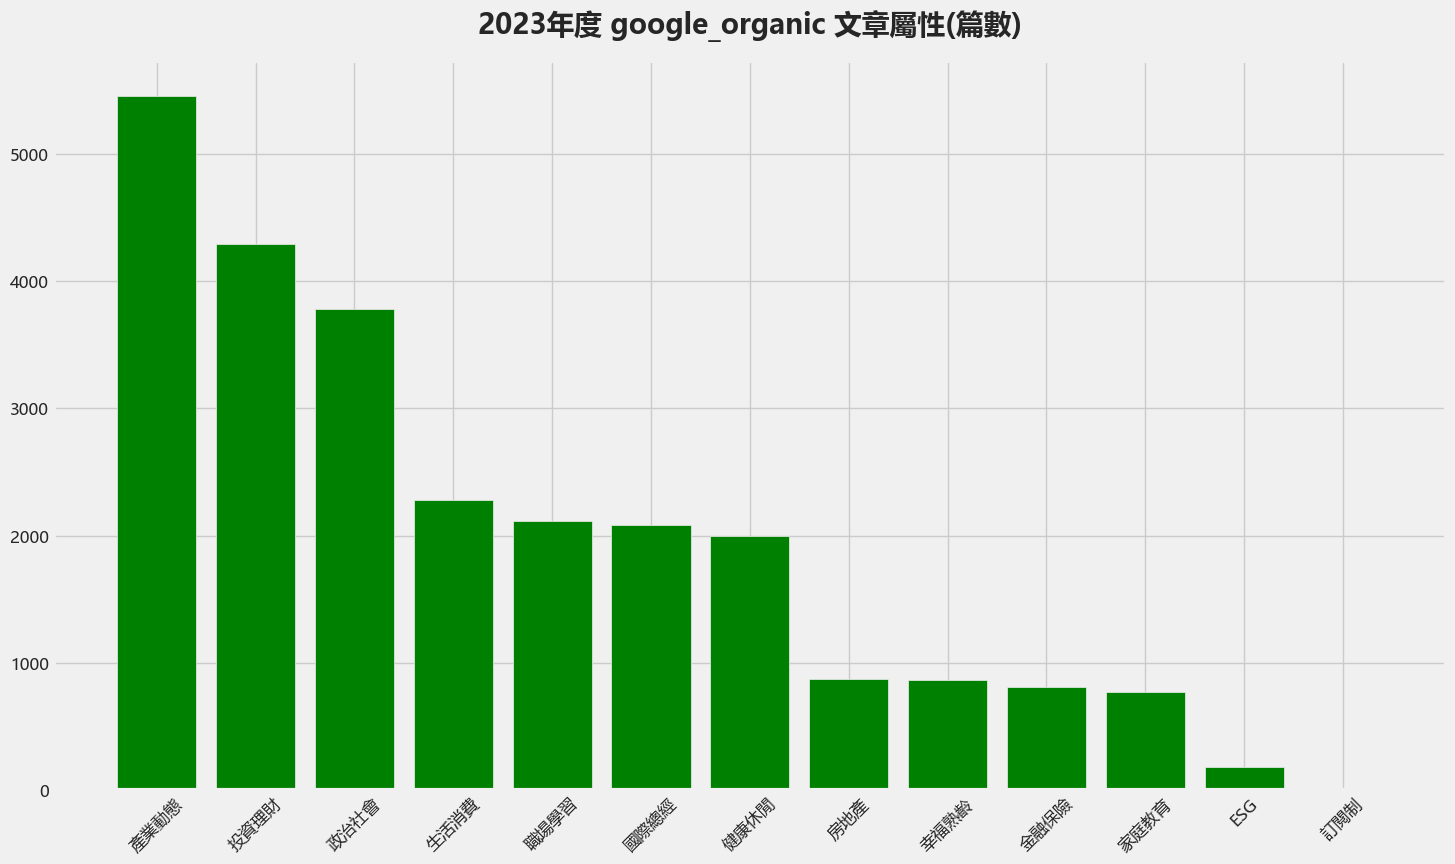

In [46]:
plt.figure(figsize = (16,9))

plt.bar(x = article_attr_counts.index,
        height = article_attr_counts.values,
        color = "green")

plt.rcParams["font.sans-serif"] = my_font_type

plt.xticks(rotation = 45, fontsize = 12)
plt.yticks(fontsize = 12)

plt.title(f"{ga_year}年度 {ga_source_medium[ga_num]} 文章屬性(篇數)", pad = 20, fontsize = 20, fontweight = "bold", fontname = my_font_type)


plt.savefig(f"./image/{ga_year}/{ga_source_medium[ga_num]}/{ga_year}_{ga_source_medium[ga_num]}_article_attr_counts.png")
plt.show()

In [47]:
article_attr_views = df_data_all.groupby("文章屬性").sum().Views.sort_values(ascending = False)

C:\Users\JoeJian\AppData\Local\Temp\ipykernel_30980\3788926252.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  article_attr_views = df_data_all.groupby("文章屬性").sum().Views.sort_values(ascending = False)


In [48]:
article_attr_views.to_csv(f"./data/{ga_year}/{ga_source_medium[ga_num]}/{ga_year}_{ga_source_medium[ga_num]}_article_attr_view.csv", encoding = "utf-8-sig")

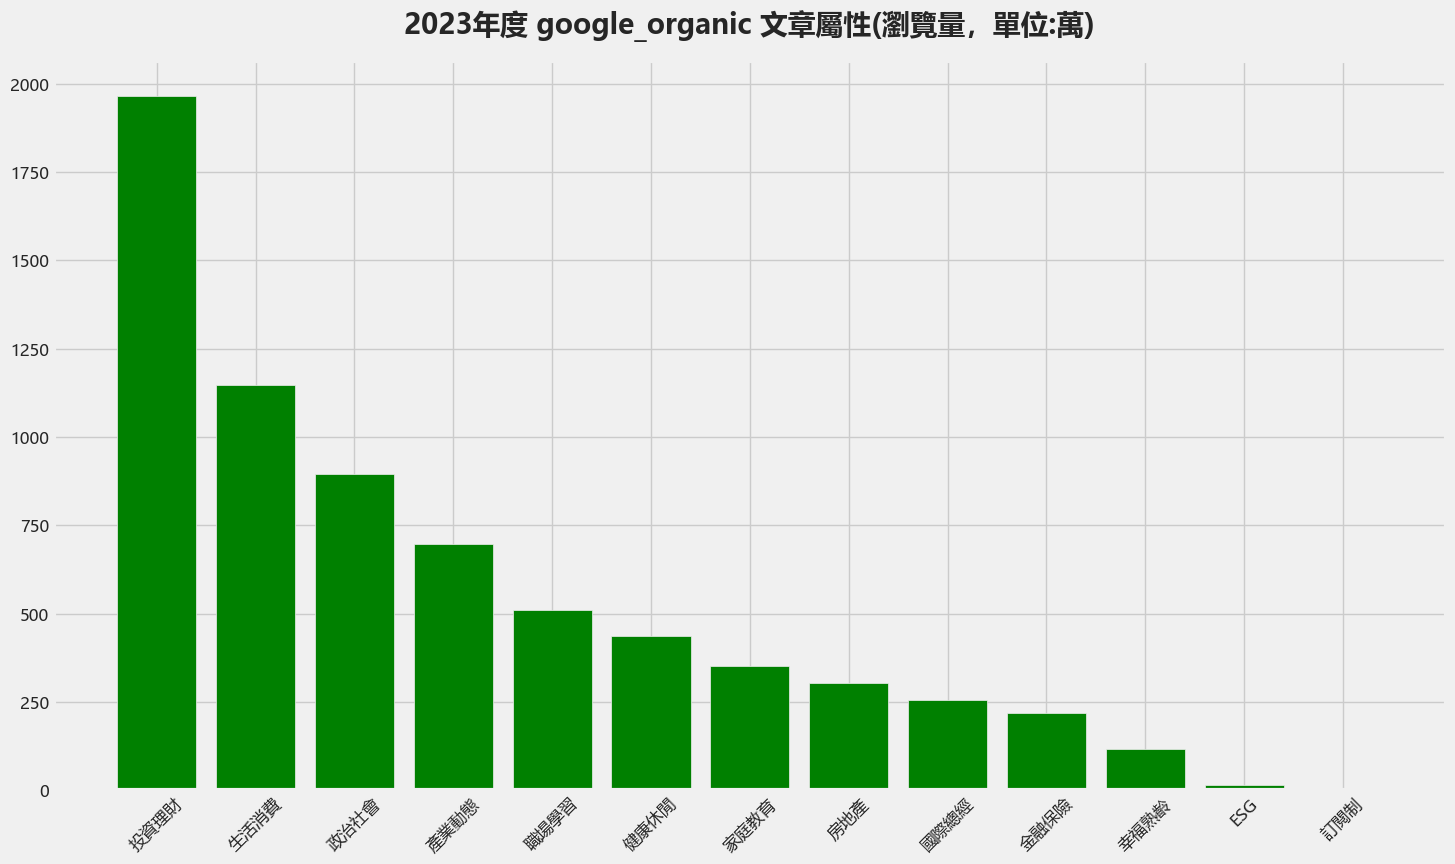

In [49]:
plt.figure(figsize = (16,9))

plt.bar(x = article_attr_views.index,
        height = (article_attr_views.values / 10000),
        color = "green")

plt.rcParams["font.sans-serif"] = my_font_type

plt.xticks(rotation = 45, fontsize = 12)
plt.yticks(fontsize = 12)

plt.title(f"{ga_year}年度 {ga_source_medium[ga_num]} 文章屬性(瀏覽量，單位:萬)", pad = 20, fontsize = 20, fontweight = "bold", fontname = my_font_type)

plt.savefig(f"./image/{ga_year}/{ga_source_medium[ga_num]}/{ga_year}_{ga_source_medium[ga_num]}_article_attr_views.png")
plt.show()

## 2-2 新文章、舊文章篇數及流量占比

### 使用 ["article_date"].dt.year 做區分

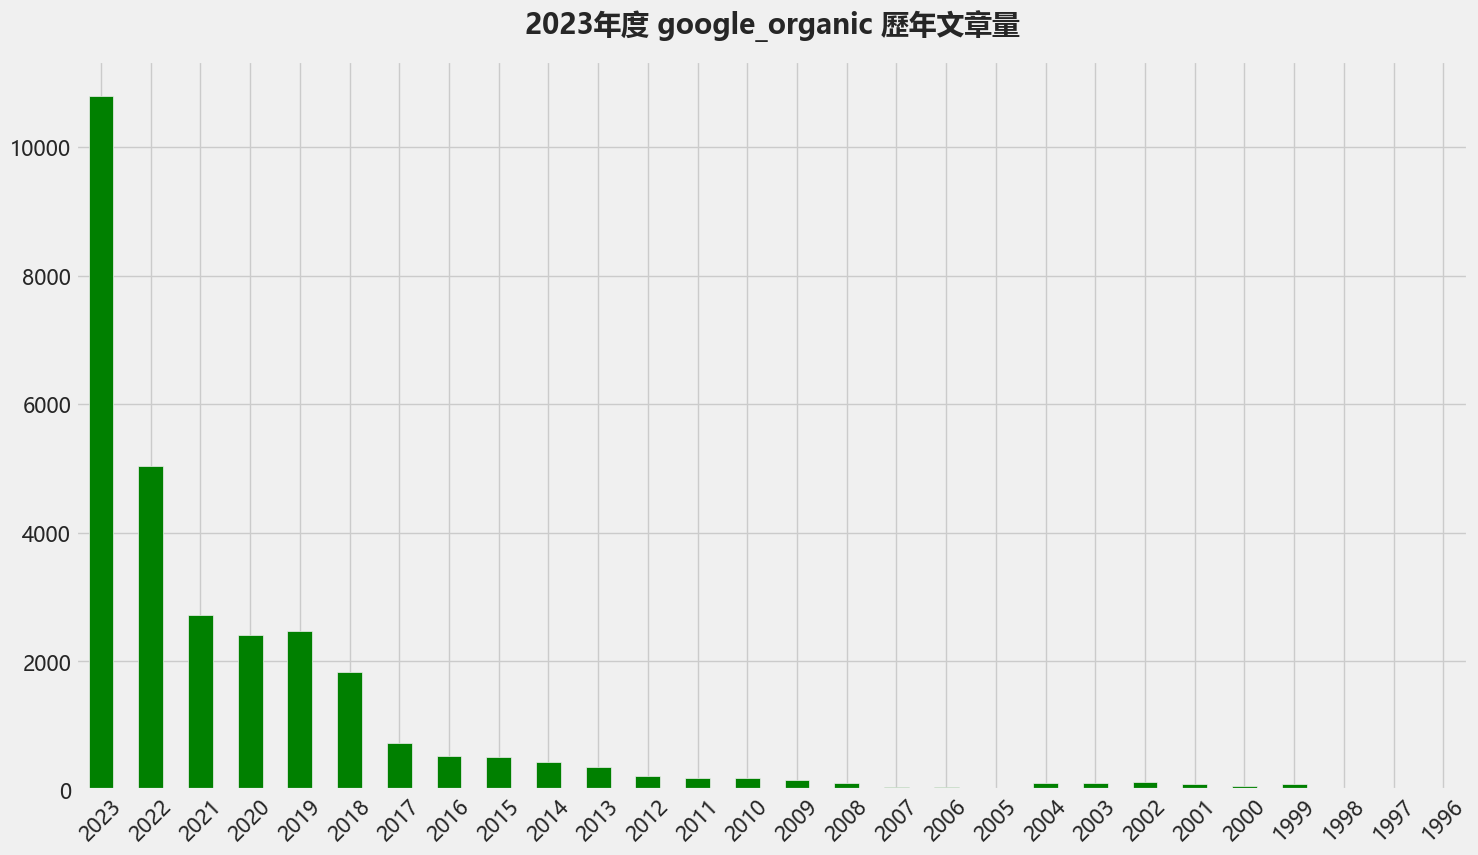

In [50]:
plt.figure(figsize = (16, 9))

df_data_all["article_date"].dt.year.value_counts().sort_index(ascending = False).plot(kind = "bar", color = "green")

plt.xticks(rotation = 45, fontsize = 15)
plt.yticks(fontsize = 15)

plt.title(f"{ga_year}年度 {ga_source_medium[ga_num]} 歷年文章量", pad = 20, fontsize = 20, fontweight = "bold", fontname = my_font_type)

plt.savefig(f"./image/{ga_year}/{ga_source_medium[ga_num]}/{ga_year}_{ga_source_medium[ga_num]}_article_years_counts.png")
plt.show()

In [51]:
df_data_all["article_year"] = df_data_all["article_date"].dt.year


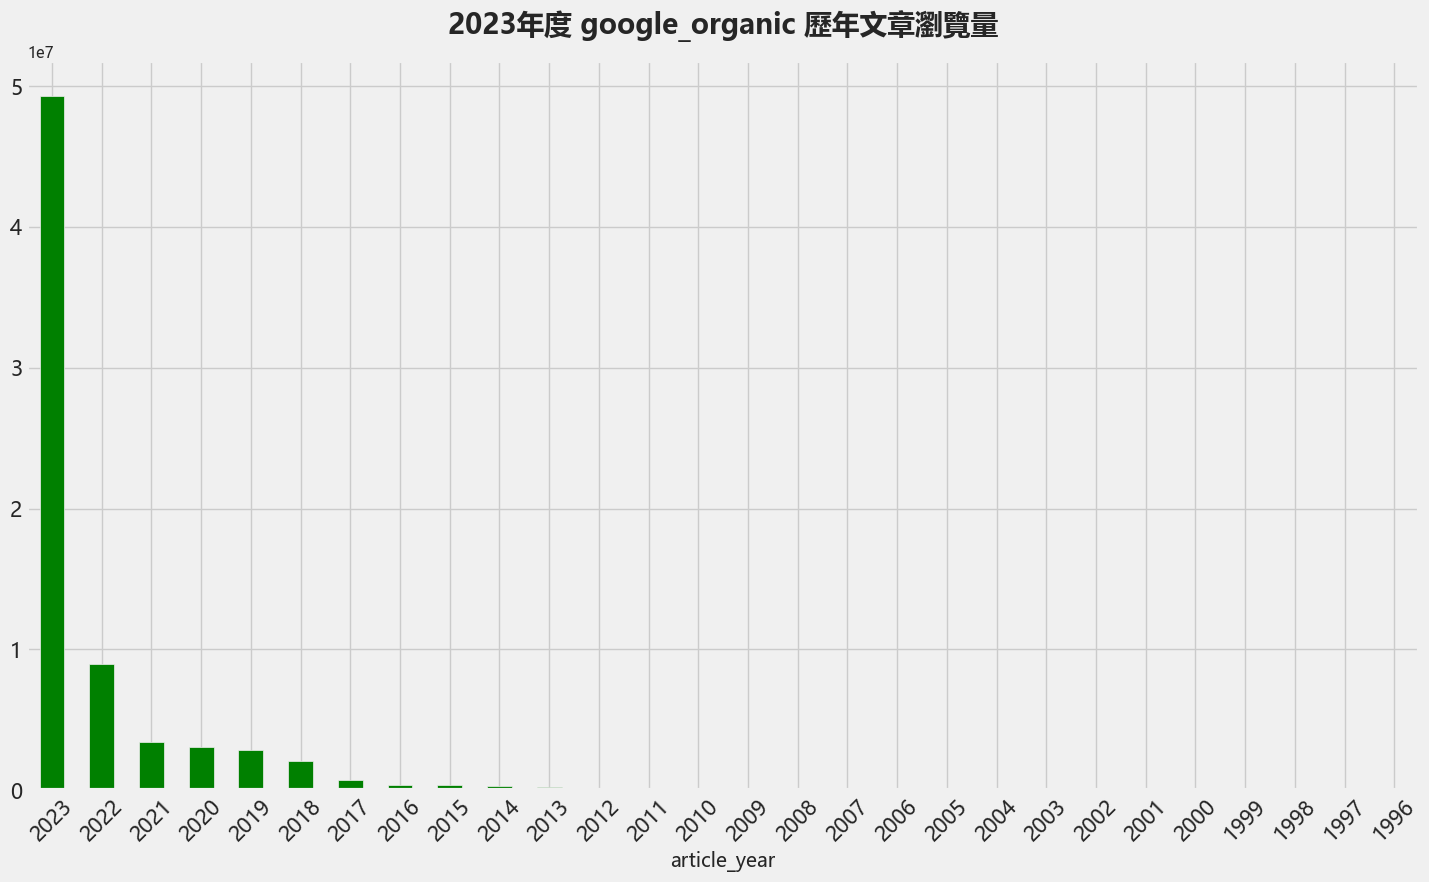

In [52]:
plt.figure(figsize = (16, 9))

df_data_all.groupby(by = "article_year")["Views"].sum().sort_index(ascending = False).plot(kind = "bar", color = "green")

plt.xticks(rotation = 45, fontsize = 15)
plt.yticks(fontsize = 15)

plt.title(f"{ga_year}年度 {ga_source_medium[ga_num]} 歷年文章瀏覽量", pad = 20, fontsize = 20, fontweight = "bold", fontname = my_font_type)

plt.savefig(f"./image/{ga_year}/{ga_source_medium[ga_num]}/{ga_year}_{ga_source_medium[ga_num]}_article_years_views.png")
plt.show()

### 該年度文章：df_new_article

In [53]:
df_new_article = df_data_all[df_data_all["article_date"].dt.year == 2023]
df_new_article.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10797 entries, 0 to 29373
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   article_id        10797 non-null  object        
 1   Views             10797 non-null  float64       
 2   PV_sum            10797 non-null  int64         
 3   文章標題              10797 non-null  object        
 4   文章來源              10797 non-null  object        
 5   文章屬性              10797 non-null  object        
 6   名人專區              2201 non-null   object        
 7   撰文                10797 non-null  object        
 8   SEO分類             10524 non-null  object        
 9   文章字數              10797 non-null  float64       
 10  上稿者               10797 non-null  object        
 11  最後修改者             10797 non-null  object        
 12  文章發布              10797 non-null  object        
 13  bt_main_categroy  10797 non-null  object        
 14  bt_sub_categroy   1079

In [54]:
df_new_article[["文章標題", "文章屬性"]].head(10)

,文章標題,文章屬性
0,明年過年放7天！2024年行事曆公布…3天以上連續假期有4個「開始排休囉」,政治社會
1,全台停班停課一覽》海葵何時最接近、基北北桃放不放颱風假？哪天風雨最大？一圖看懂影響時程,生活消費
2,杜蘇芮龜速移動「加速重整」，今威脅最大！南部風雨增強、外圍環流小心致災豪雨，6號颱風卡努又來？,生活消費
3,現金6000元4/6就能領！發放3階段「怎麼領、需要什麼資料」 3/22開放登記,生活消費
4,「新青年安心成家房貸」8/1上路懶人包：利率、貸款資格一次看！第一次買房才能申請？破解3大迷思,房地產
5,「太太輕生掛在16樓高空」前科技部長陳良基辭官退休，陪妻度過憂鬱症：結婚發誓照顧到老，說話要算數,職場學習
6,50歲勞保年資滿25年，老年給付可以領多少？2張表無腦看：一次領還是月領好？年金改革有什麼影響,投資理財
7,2023重陽敬老金懶人包，最高領2萬！全台各縣市65歲以上領取資格、發放金額、何時能領一次看,幸福熟齡
8,現金6000元ATM怎麼領？「簡單5步驟」錢就到手 領完7-11、全家咖啡還能買1送1,生活消費
9,2023報稅攻略》所得稅級距全圖解：年薪60萬、100萬、200萬要繳多少稅？上班族存股ET...,投資理財


In [55]:
df_new_article.to_csv(f"./data/{ga_year}/{ga_source_medium[ga_num]}/{ga_year}_{ga_source_medium[ga_num]}_new_article.csv", encoding = "utf-8-sig")

In [56]:
new_article_attr_counts = df_new_article["文章屬性"].value_counts()

In [57]:
new_article_attr_counts.to_csv(f"./data/{ga_year}/{ga_source_medium[ga_num]}/{ga_year}_{ga_source_medium[ga_num]}_new_article_attr_counts.csv", encoding = "utf-8-sig")

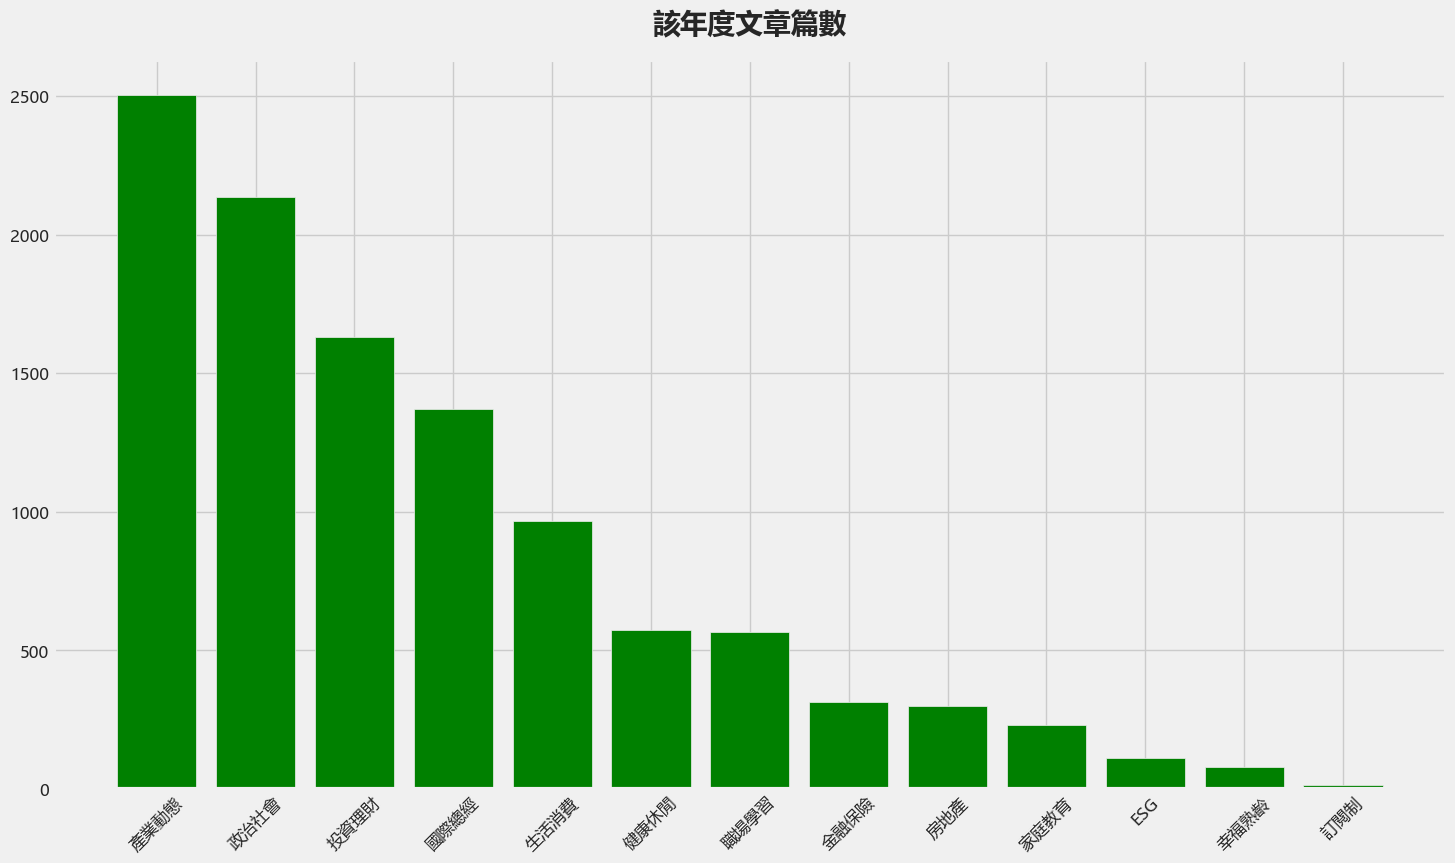

In [58]:
plt.figure(figsize = (16, 9))

plt.bar(x = new_article_attr_counts.index,
        height = new_article_attr_counts.values,
        color = "green")

plt.rcParams["font.sans-serif"] = my_font_type

plt.xticks(rotation = 45, fontsize = 12)
plt.yticks(fontsize = 12)

plt.title("該年度文章篇數", pad = 20, fontsize = 20, fontweight = "bold", fontname = my_font_type)

plt.savefig(f"./image/{ga_year}/{ga_source_medium[ga_num]}/{ga_year}_{ga_source_medium[ga_num]}_new_article_attr_counts.png")
plt.show()

In [59]:
new_article_attr_views = df_new_article.groupby("文章屬性").sum().Views.sort_values(ascending = False)

C:\Users\JoeJian\AppData\Local\Temp\ipykernel_30980\67163466.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  new_article_attr_views = df_new_article.groupby("文章屬性").sum().Views.sort_values(ascending = False)


In [60]:
new_article_attr_views.to_csv(f"./data/{ga_year}/{ga_source_medium[ga_num]}/{ga_year}_{ga_source_medium[ga_num]}_new_article_attr_views.csv", encoding = "utf-8-sig")

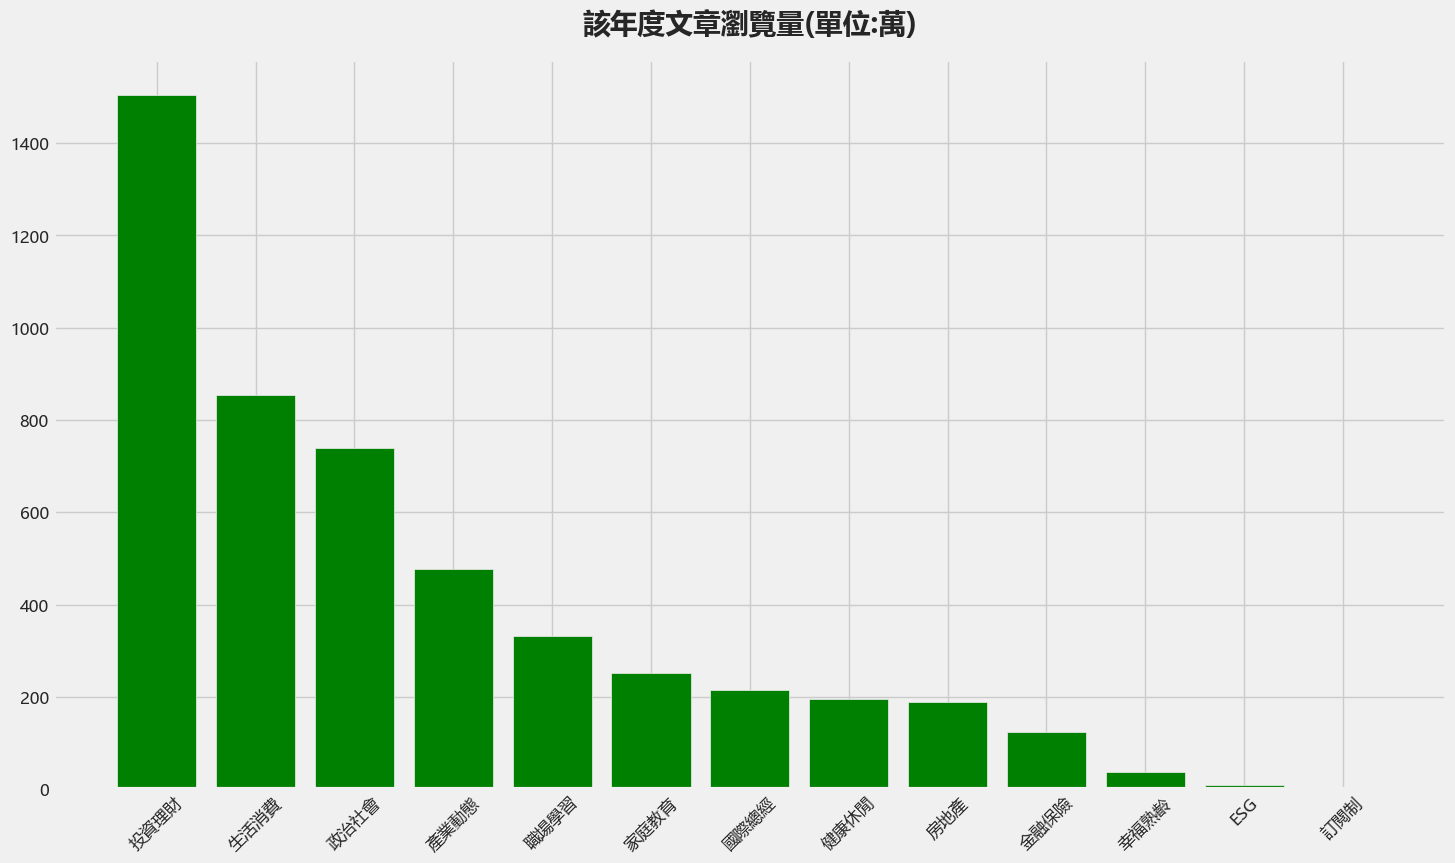

In [61]:
plt.figure(figsize = (16, 9))

plt.bar(x = new_article_attr_views.index,
        height = (new_article_attr_views.values / 10000),
        color = "green")

plt.rcParams["font.sans-serif"] = my_font_type

plt.xticks(rotation = 45, fontsize = 12)
plt.yticks(fontsize = 12)

plt.title("該年度文章瀏覽量(單位:萬)", pad = 20, fontsize = 20, fontweight = "bold", fontname = my_font_type)

plt.savefig(f"./image/{ga_year}/{ga_source_medium[ga_num]}/{ga_year}_{ga_source_medium[ga_num]}_new_article_attr_views.png")
plt.show()

### 舊文：df_old_article

In [62]:
df_old_article = df_data_all[df_data_all["article_date"].dt.year != 2023]
df_old_article.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18596 entries, 22 to 29392
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   article_id        18596 non-null  object        
 1   Views             18596 non-null  float64       
 2   PV_sum            18596 non-null  int64         
 3   文章標題              18596 non-null  object        
 4   文章來源              16549 non-null  object        
 5   文章屬性              14727 non-null  object        
 6   名人專區              6046 non-null   object        
 7   撰文                18569 non-null  object        
 8   SEO分類             17283 non-null  object        
 9   文章字數              18596 non-null  float64       
 10  上稿者               8402 non-null   object        
 11  最後修改者             17568 non-null  object        
 12  文章發布              18596 non-null  object        
 13  bt_main_categroy  18596 non-null  object        
 14  bt_sub_categroy   185

In [63]:
df_old_article[["文章標題", "文章屬性"]].head(10)

,文章標題,文章屬性
22,勞保勞退是什麼?勞工退休金資格與年資計算懶人包一篇指南！,生活消費
25,2023年贈與稅免稅額244萬！長輩財富傳承要懂的遺贈節稅事：這樣做1個月可給子女1176萬,投資理財
26,殖利率是什麼意思？3分鐘搞懂怎麼計算，了解並非高的股票就是好！,投資理財
27,存股是什麼？2023有適合推薦投資的嗎？學會看指標，包準輕鬆學會怎麼買！,投資理財
36,孝順姊弟想把父親遺產全留給母親，沒想拋棄繼承辦完才發現大事不妙！關於繼承一定要懂的重要事,房地產
48,【2023更新】國民年金是什麼？一定要繳嗎？給付方式、申請管道一篇全解析！,金融保險
53,業者偷偷降速？NCC點名這2家「4G最龜速」 5大電信實測出爐，這家最快！,生活消費
62,月月領股息「匯費」被扣好扣滿！ 1招配息不打折「一年最少省下120元」,投資理財
66,明明吃不多 肚子卻鼓鼓的？腹脹隱含７大危機,健康休閒
68,又發錢了！藝FUN券再加碼「這些人」能領1200元…何時發放、怎麼登記、使用期限範圍一次看,生活消費


In [64]:
df_old_article.to_csv(f"./data/{ga_year}/{ga_source_medium[ga_num]}/{ga_year}_{ga_source_medium[ga_num]}_old_article.csv", encoding = "utf-8-sig")

In [65]:
old_article_attr_counts = df_old_article["文章屬性"].value_counts()

In [66]:
old_article_attr_counts.to_csv(f"./data/{ga_year}/{ga_source_medium[ga_num]}/{ga_year}_{ga_source_medium[ga_num]}_old_article_attr_counts.csv", encoding = "utf-8-sig")

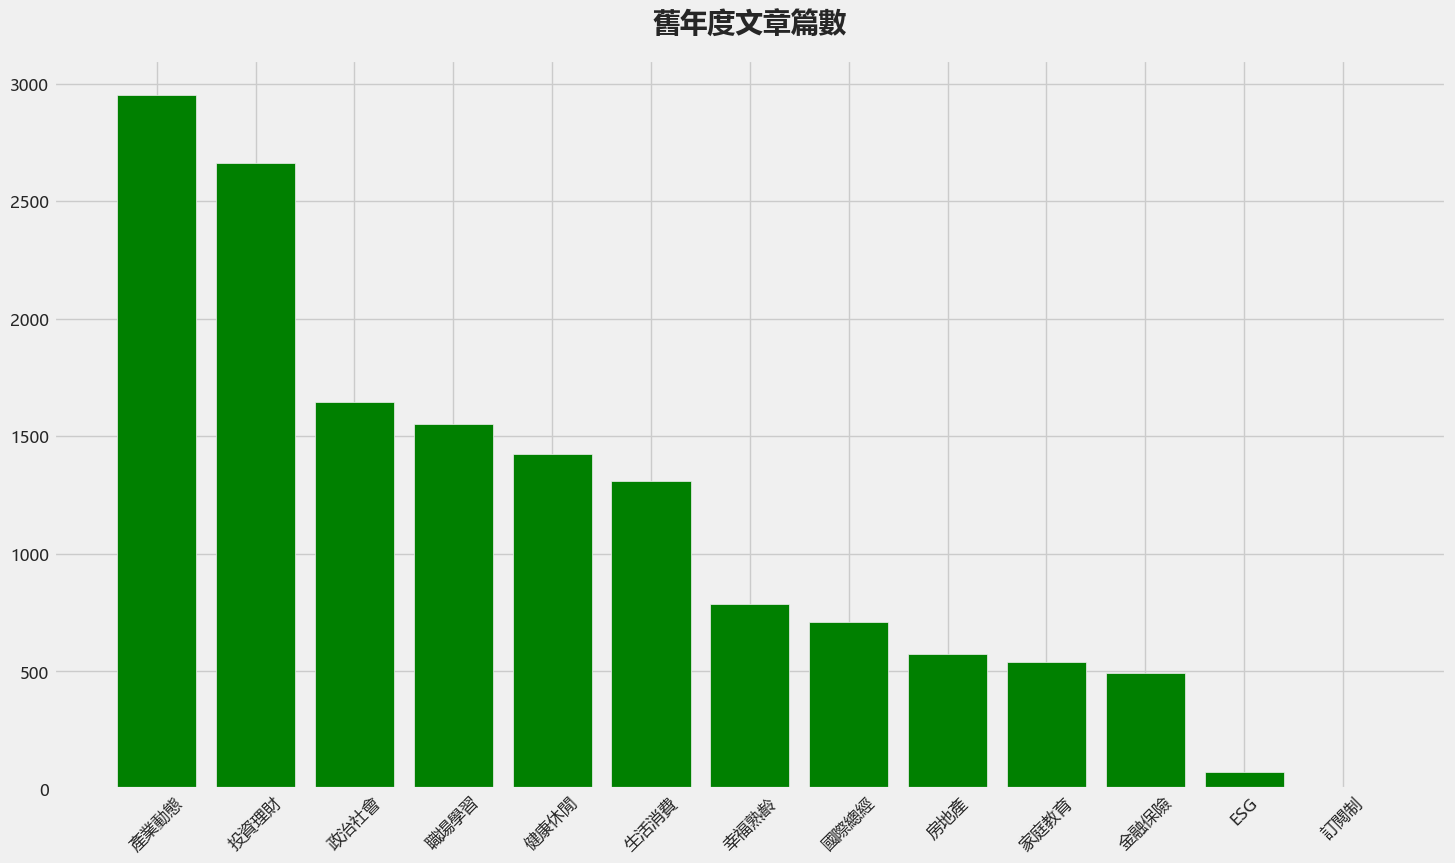

In [67]:
plt.figure(figsize = (16, 9))

plt.bar(x = old_article_attr_counts.index,
        height = old_article_attr_counts.values,
        color = "green")

plt.rcParams["font.sans-serif"] = my_font_type

plt.xticks(rotation = 45, fontsize = 12)
plt.yticks(fontsize = 12)

plt.title("舊年度文章篇數", pad = 20, fontsize = 20, fontweight = "bold", fontname = my_font_type)

plt.savefig(f"./image/{ga_year}/{ga_source_medium[ga_num]}/{ga_year}_{ga_source_medium[ga_num]}_old_article_attr_counts.png")
plt.show()

In [68]:
old_article_attr_views = df_old_article.groupby("文章屬性").sum().Views.sort_values(ascending = False)

C:\Users\JoeJian\AppData\Local\Temp\ipykernel_30980\1970446934.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  old_article_attr_views = df_old_article.groupby("文章屬性").sum().Views.sort_values(ascending = False)


In [69]:
old_article_attr_views.to_csv(f"./data/{ga_year}/{ga_source_medium[ga_num]}/{ga_year}_{ga_source_medium[ga_num]}_old_article_attr_views.csv", encoding = "utf-8-sig")

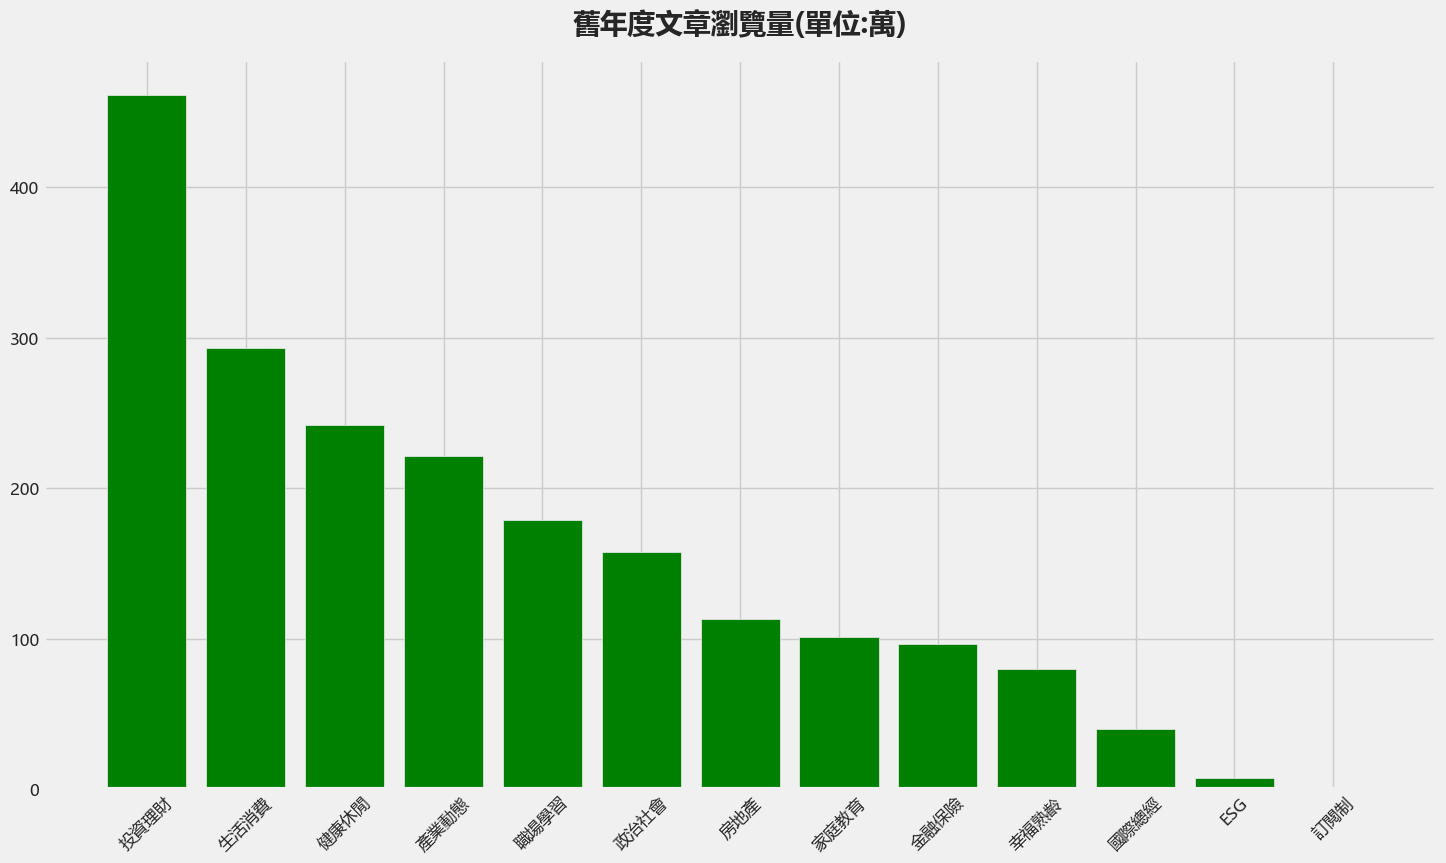

In [70]:
plt.figure(figsize = (16, 9))

plt.bar(x = old_article_attr_views.index,
        height = (old_article_attr_views.values / 10000),
        color = "green")

plt.rcParams["font.sans-serif"] = my_font_type

plt.xticks(rotation = 45, fontsize = 12)
plt.yticks(fontsize = 12)

plt.title("舊年度文章瀏覽量(單位:萬)", pad = 20, fontsize = 20, fontweight = "bold", fontname = my_font_type)

plt.savefig(f"./image/{ga_year}/{ga_source_medium[ga_num]}/{ga_year}_{ga_source_medium[ga_num]}_old_article_attr_views.png")
plt.show()

## 2-3 該年度每月文章比例

### 使用article_date.dt.month來看該月份文章比例有多少

In [71]:
df_new_article["article_month"] = df_new_article["article_date"].dt.month

C:\Users\JoeJian\AppData\Local\Temp\ipykernel_30980\1928150024.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_article["article_month"] = df_new_article["article_date"].dt.month


In [72]:
list_article_attr = df_new_article["文章屬性"].unique()

In [73]:
df_month_views = df_new_article.groupby(by = ["article_month", "文章屬性"])["Views"].sum()

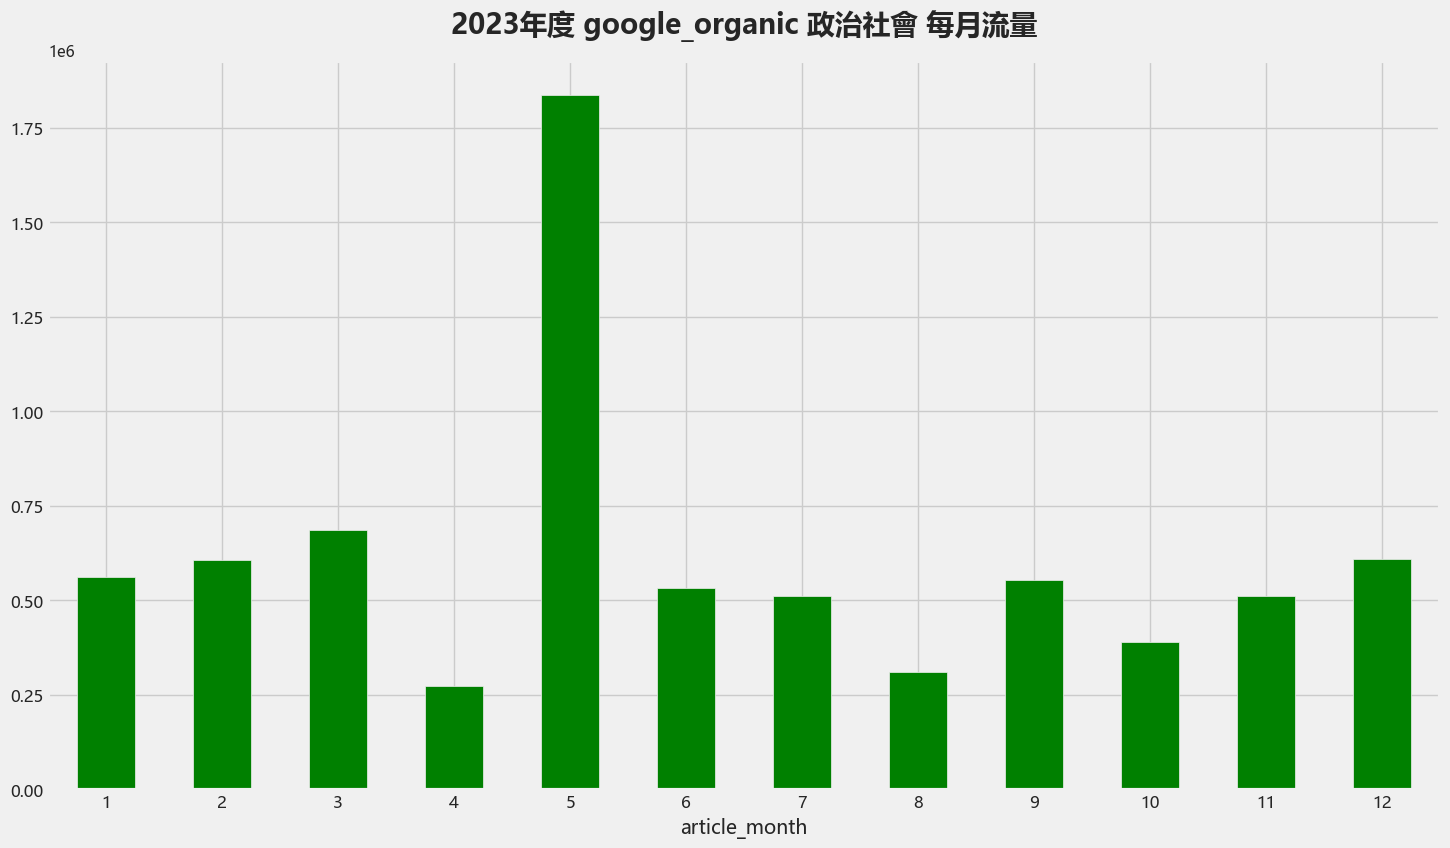

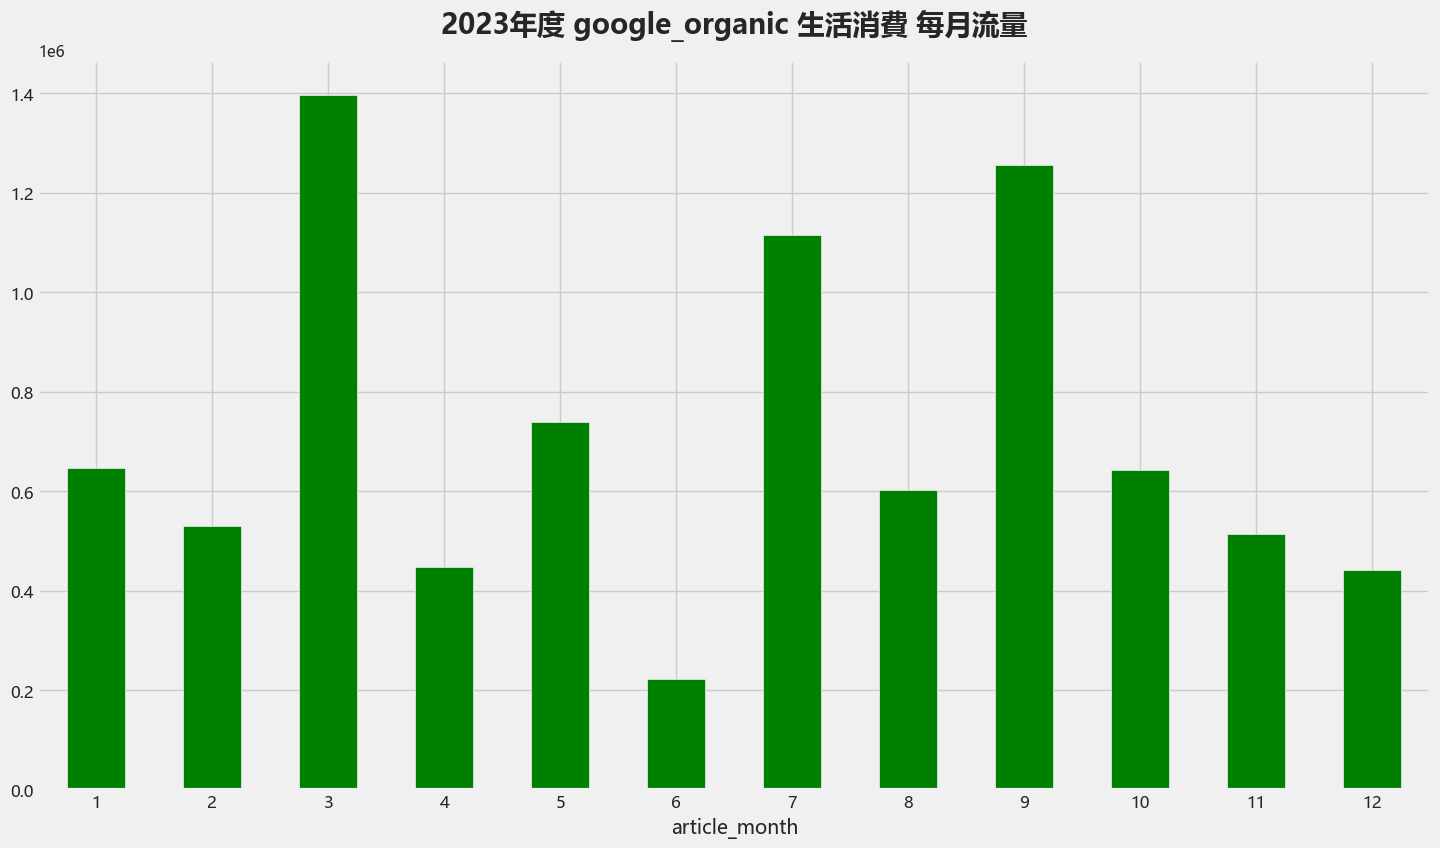

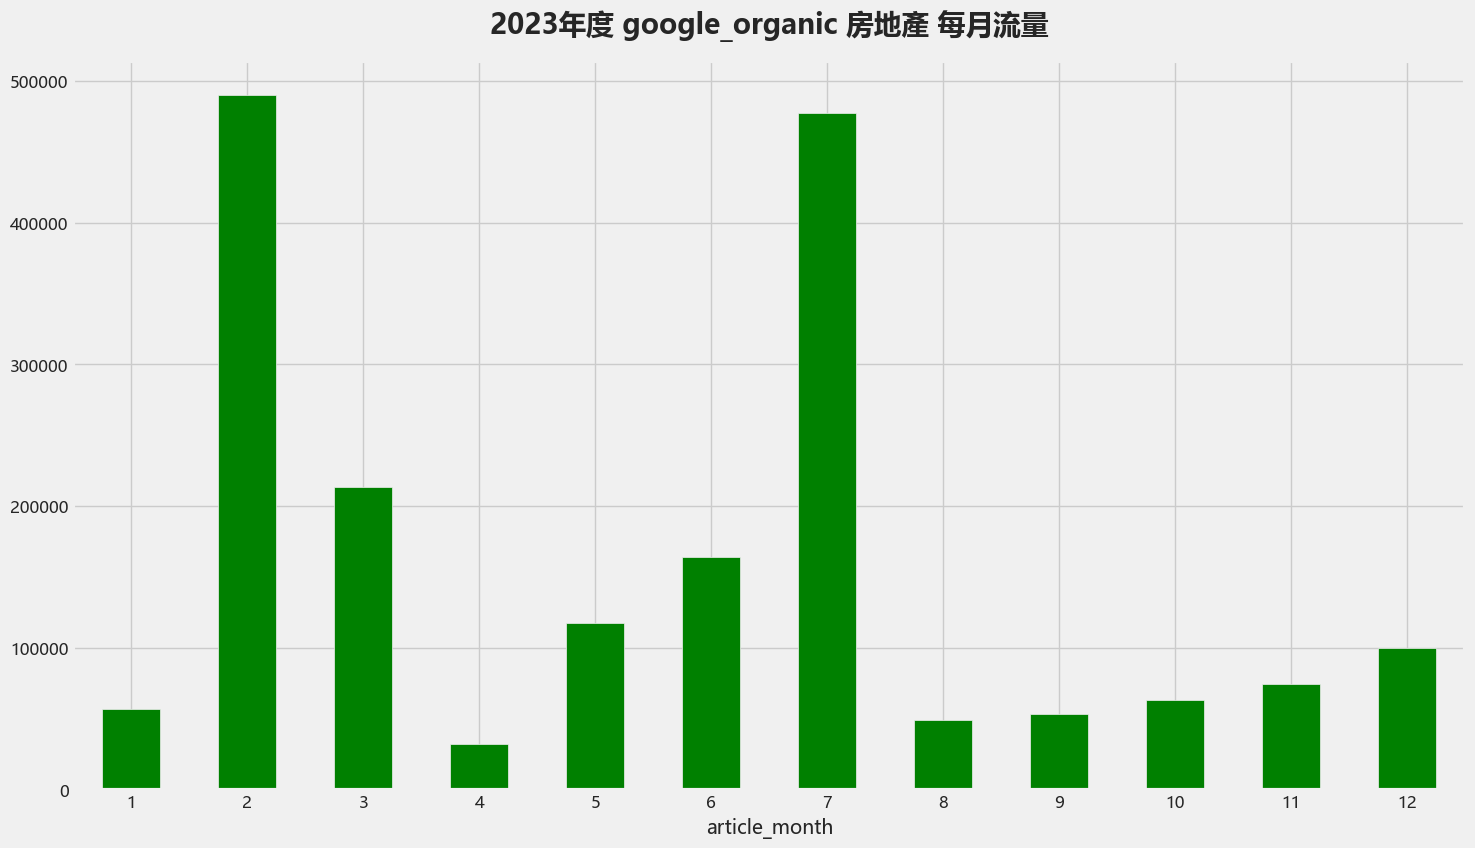

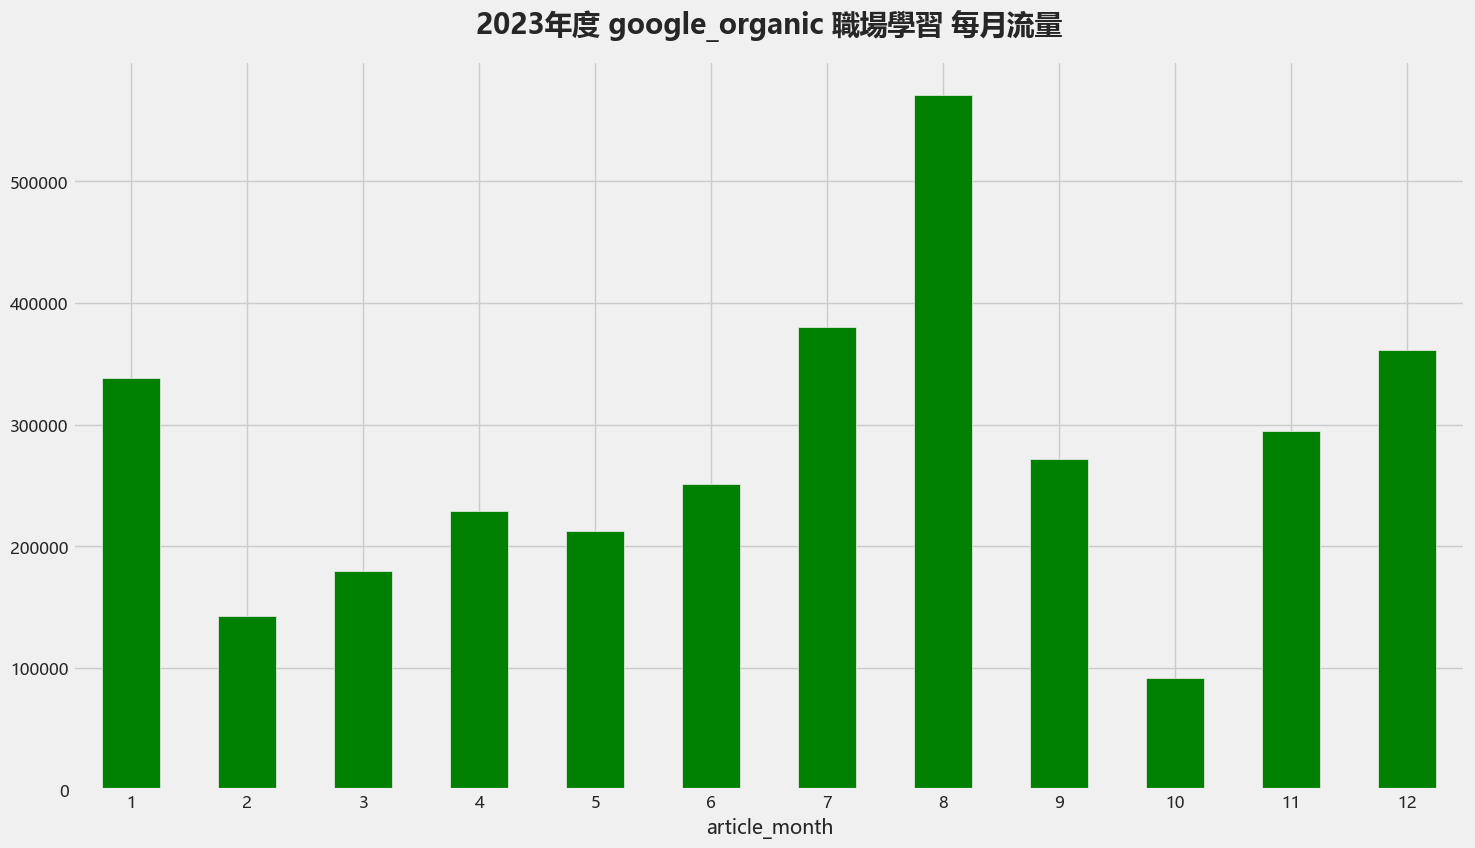

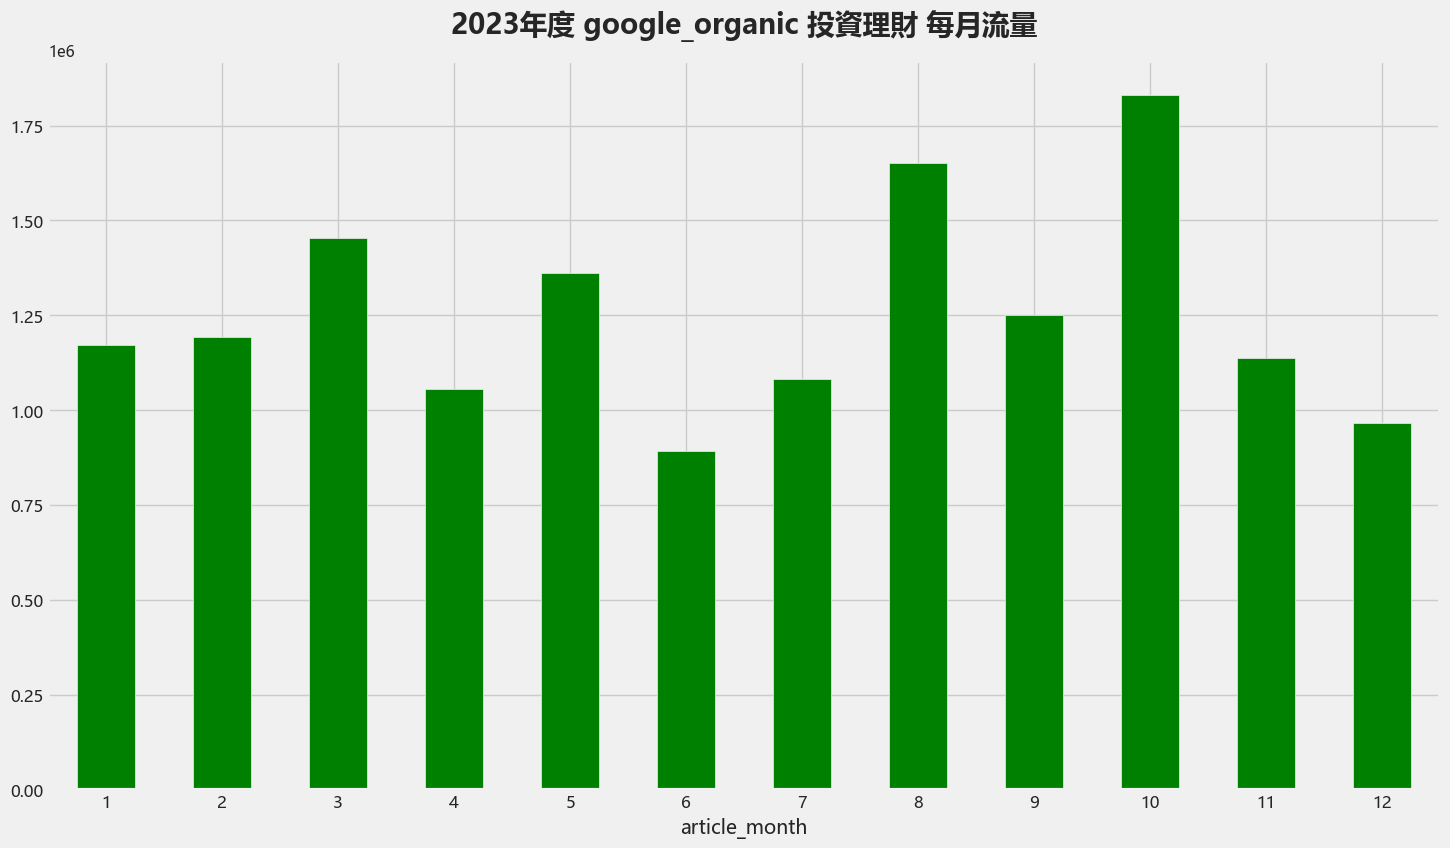

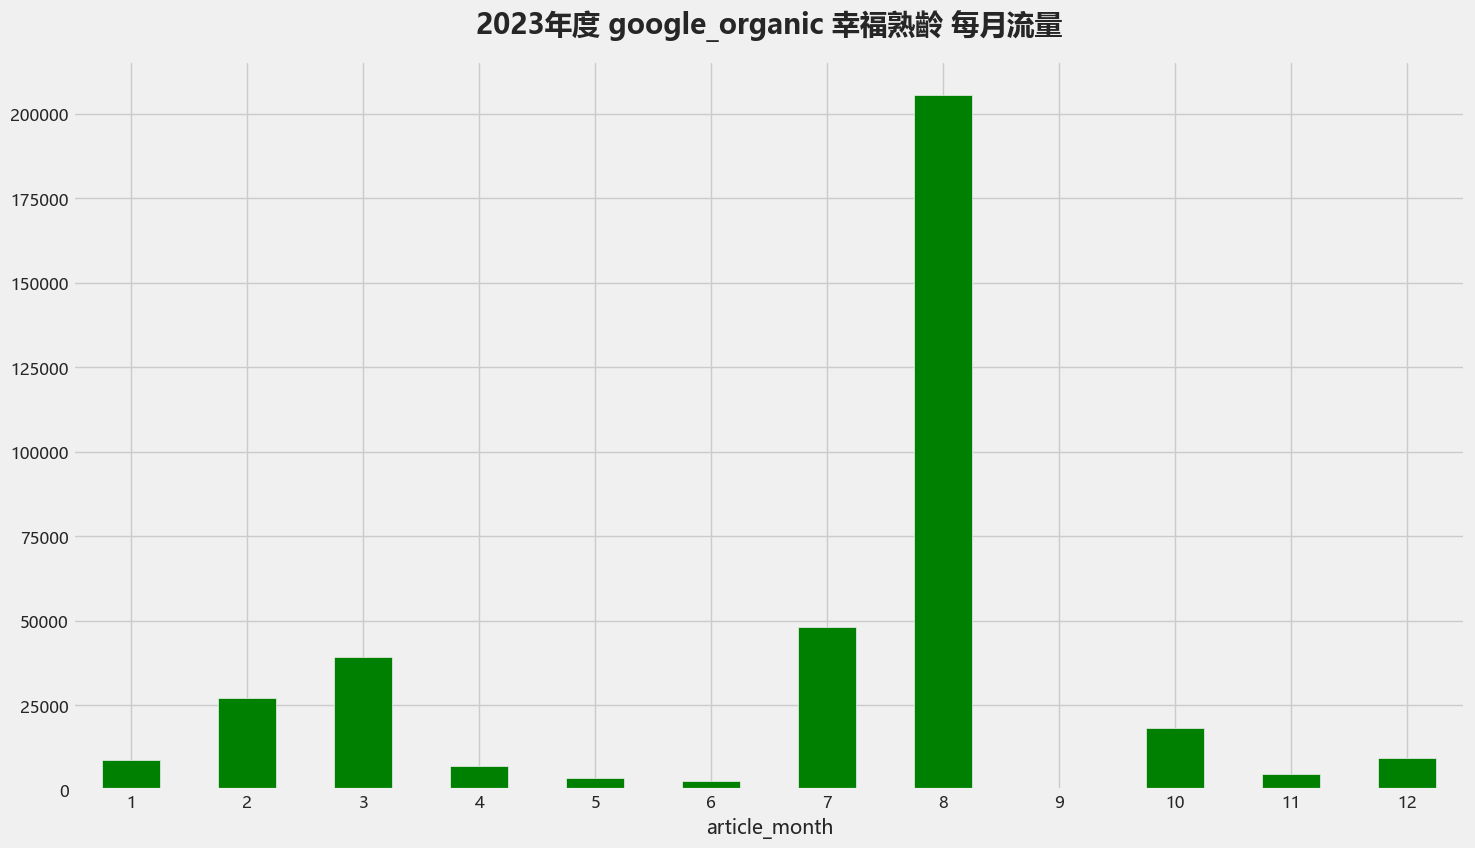

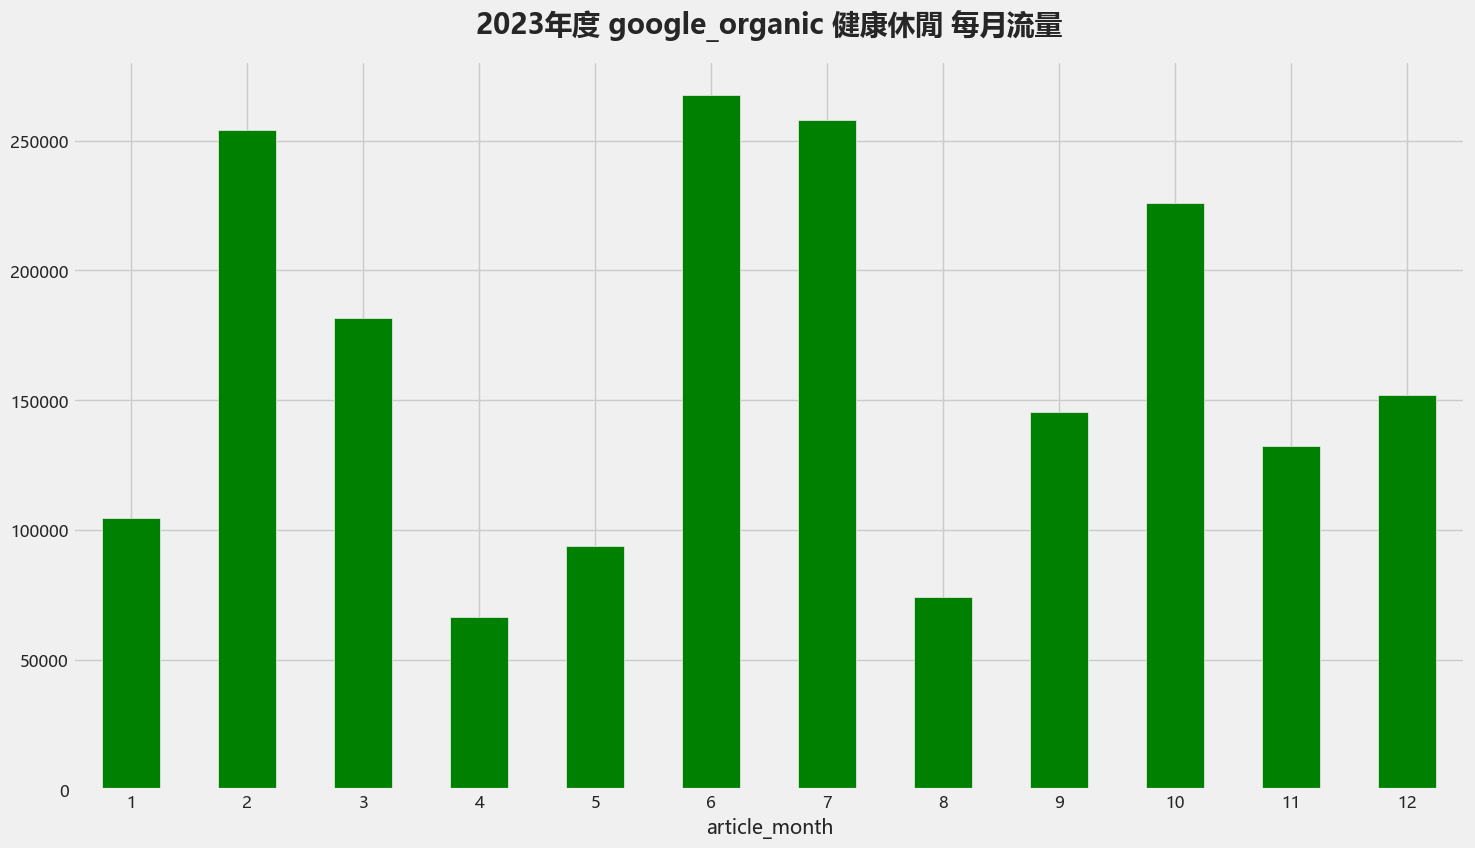

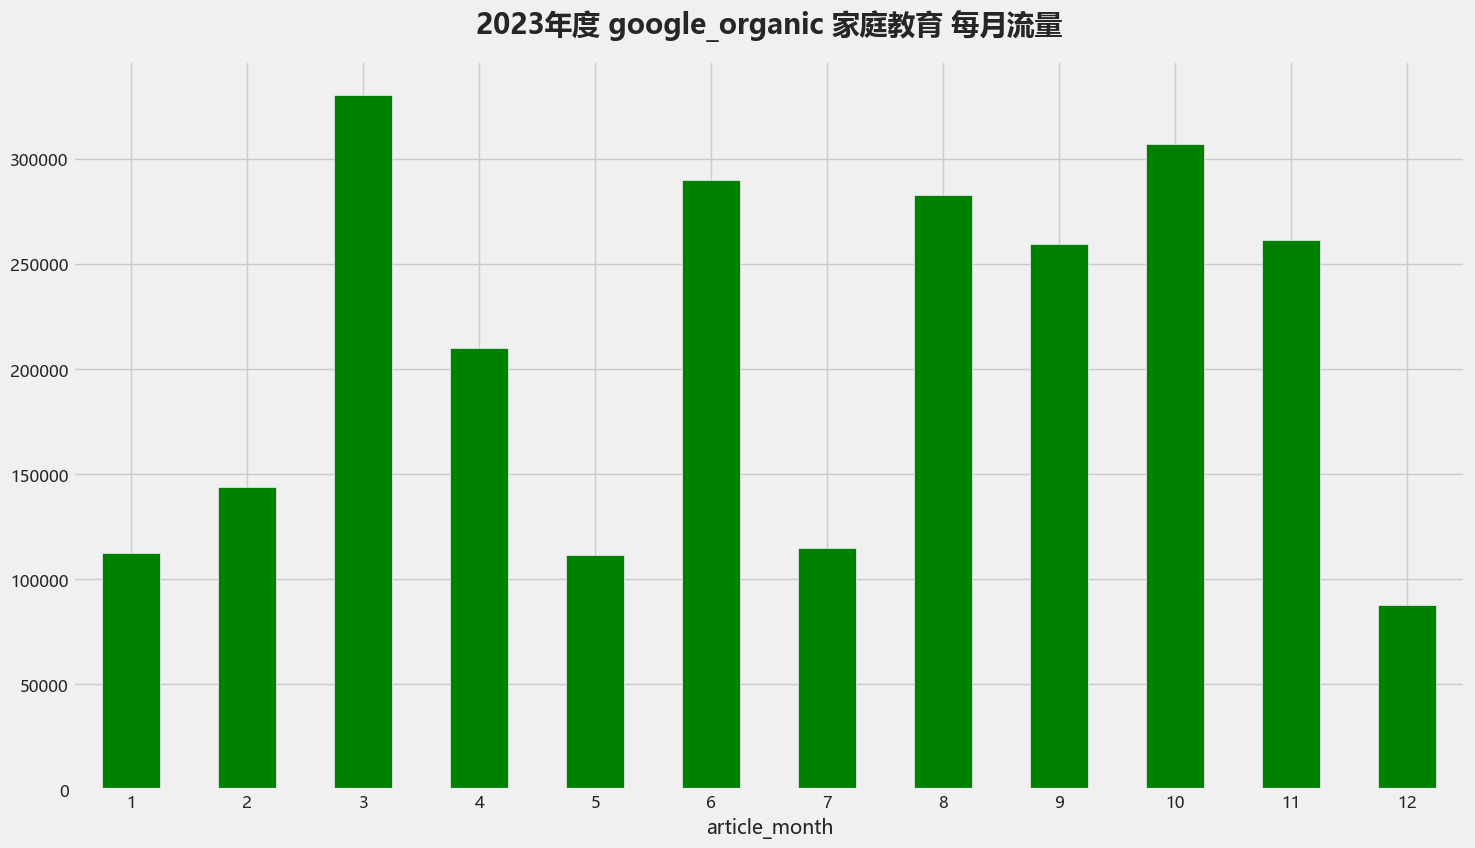

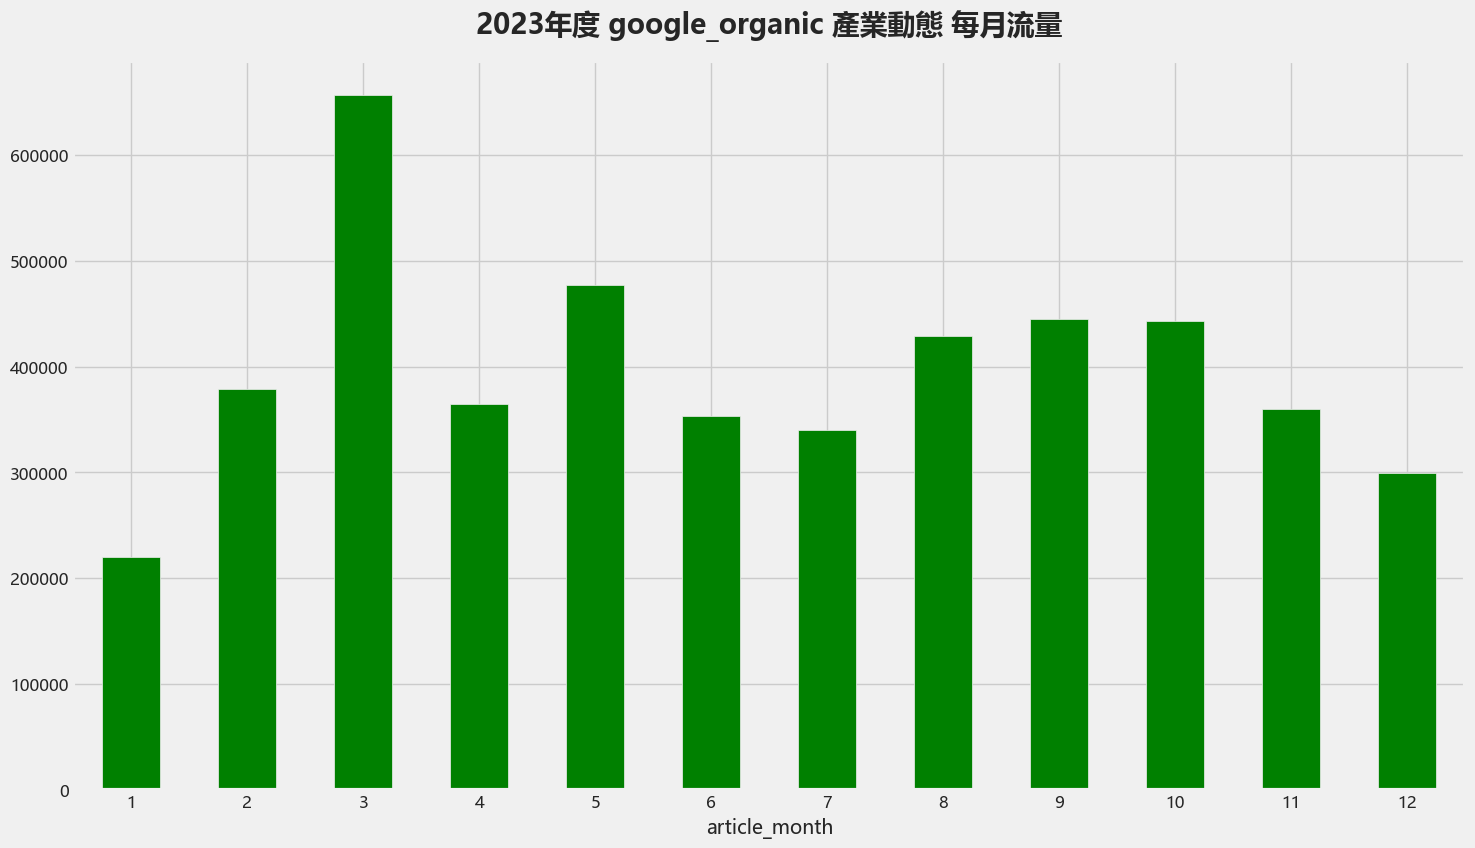

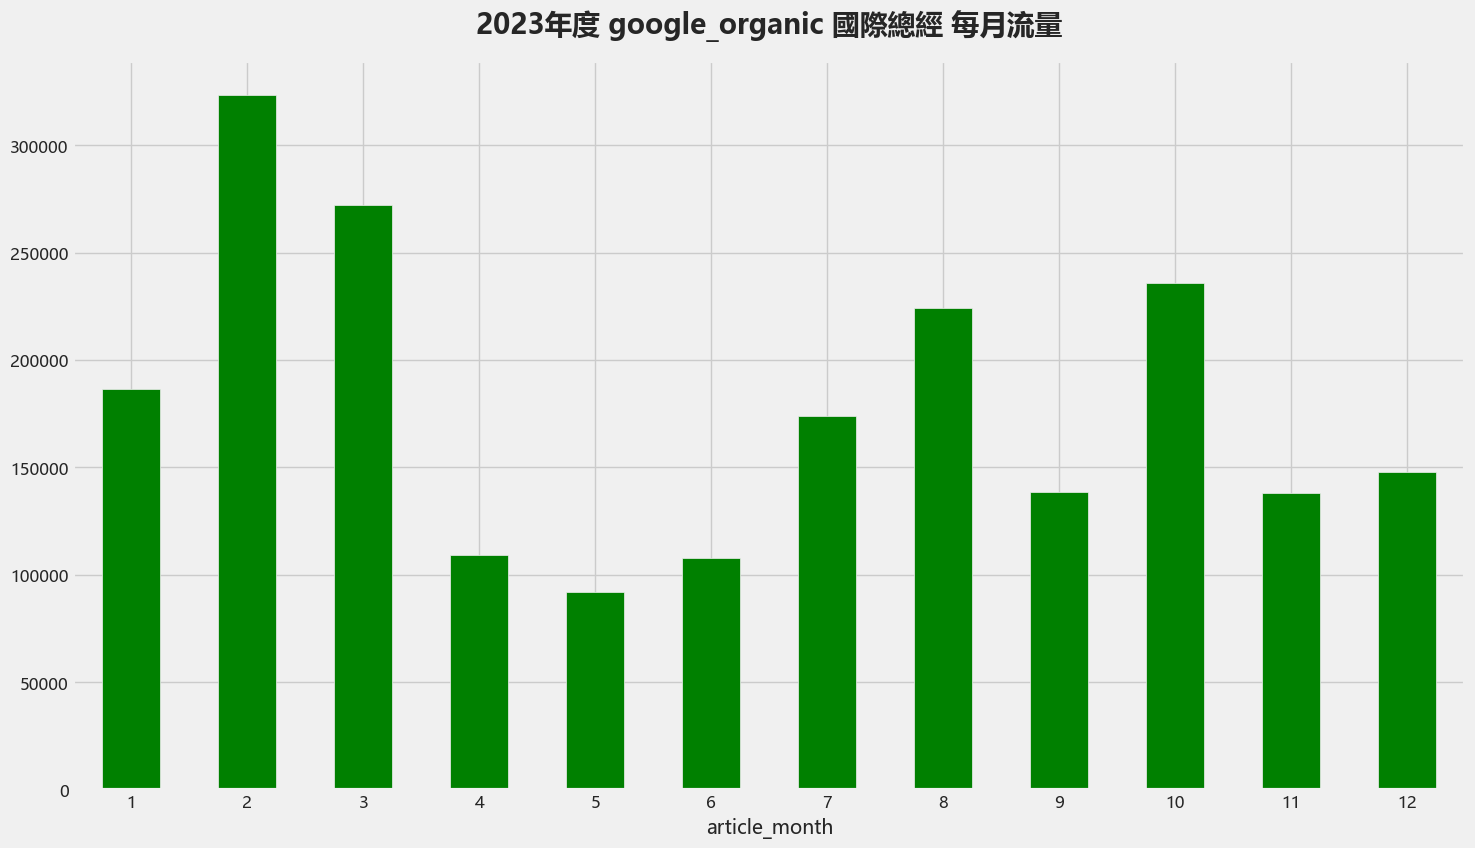

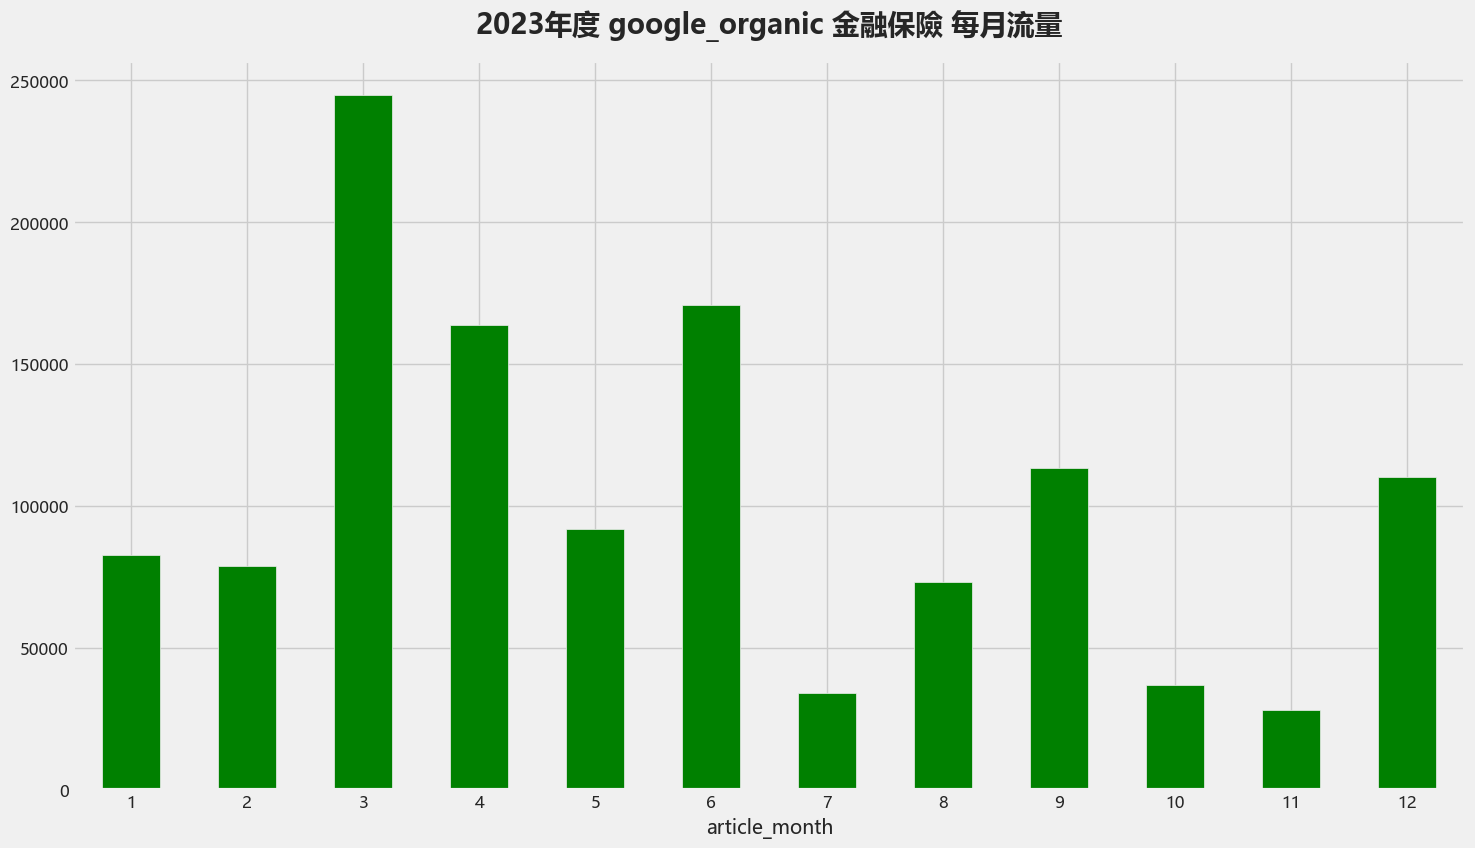

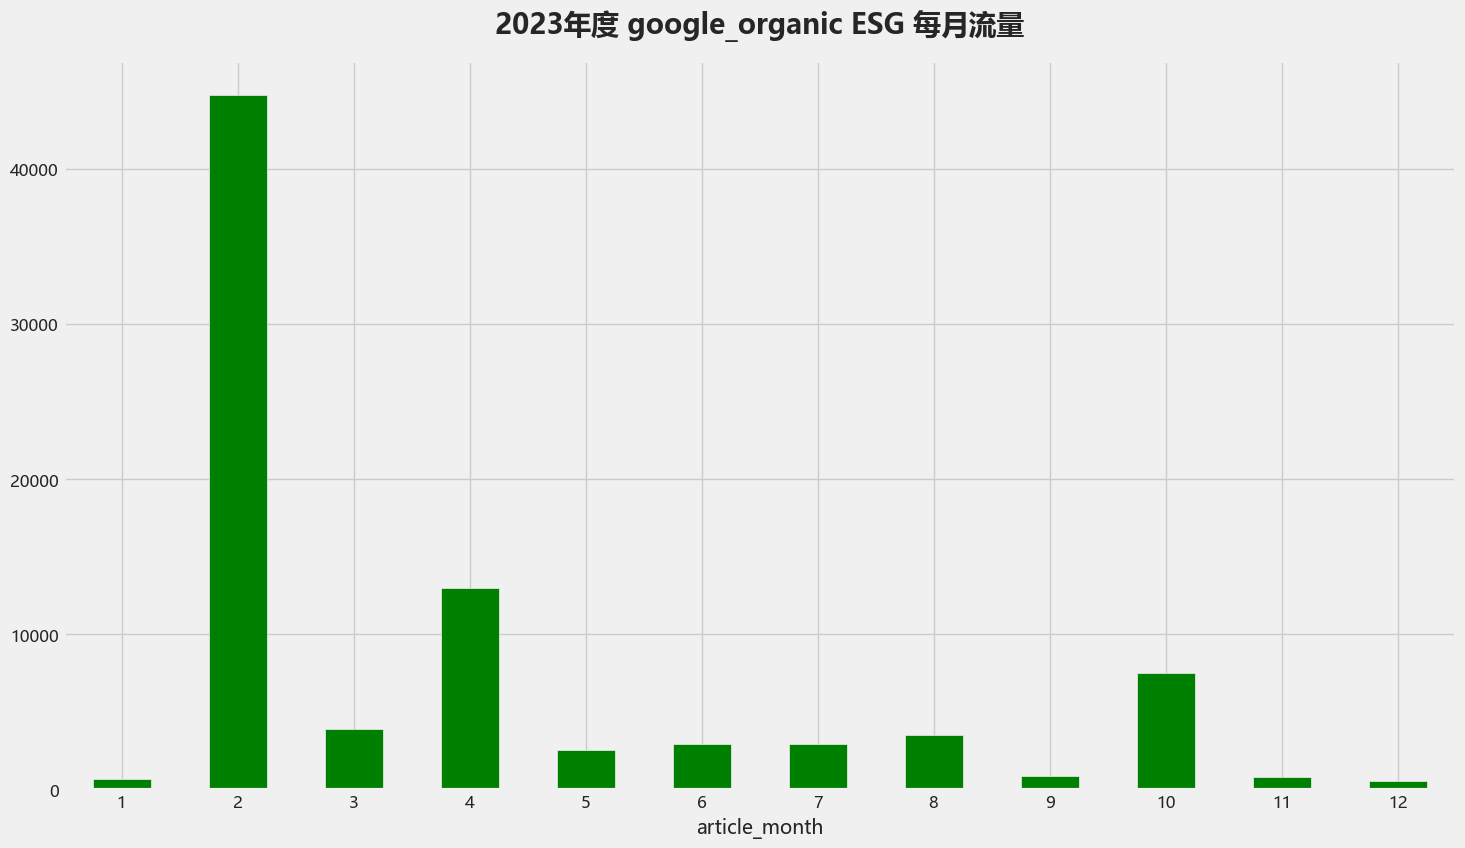

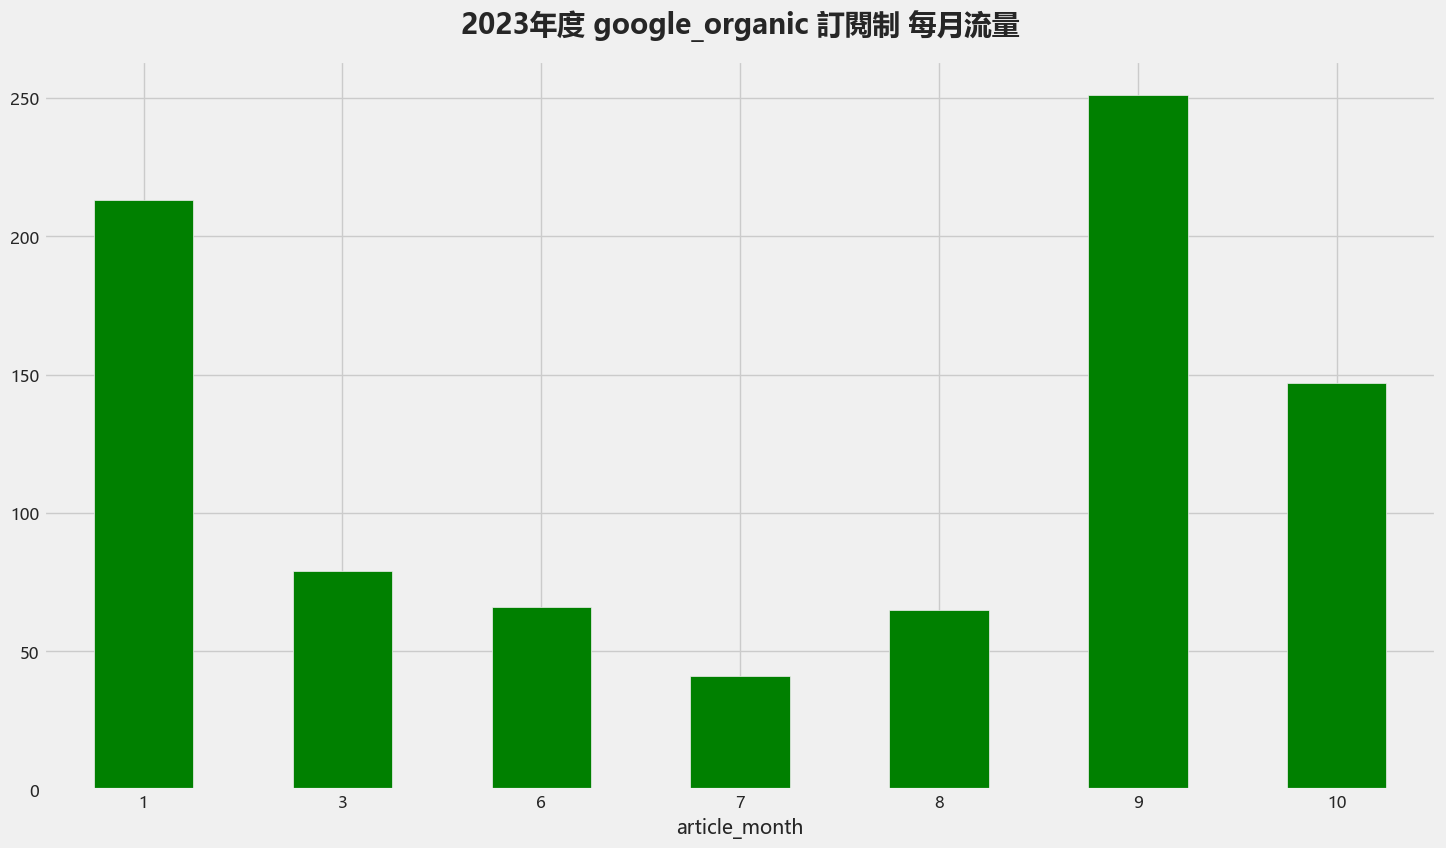

In [74]:
for i in range(len(list_article_attr)):
    plt.figure(figsize = (16, 9))
    
    df_month_views.loc[:, list_article_attr[i]].plot(kind = "bar", color = "green")
    plt.title(f"{ga_year}年度 {ga_source_medium[ga_num]} {list_article_attr[i]} 每月流量", pad = 20, fontsize = 20, fontweight = "bold", fontname = my_font_type)
    
    plt.xticks(rotation = 0, fontsize = 12)
    plt.yticks(fontsize = 12)
    
    plt.savefig(f"./image/{ga_year}/{ga_source_medium[ga_num]}/month/{ga_year}_{ga_source_medium[ga_num]}_{list_article_attr[i]}_month_attr_views.png")
    plt.show()

# 3. 語意分析

In [75]:
## NLP

import jieba
import jieba.analyse
# For TF-IDF

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [76]:
inputSTR_LIST = []

for num in range(len(df_data_all)):
    inputSTR_LIST.append(df_data_all['文章標題'][num])
    inputSTR = " ".join(inputSTR_LIST)

inputSTR = inputSTR.replace('\u3000', ' ')
inputSTR[:100]

'明年過年放7天！2024年行事曆公布…3天以上連續假期有4個「開始排休囉」 全台停班停課一覽》海葵何時最接近、基北北桃放不放颱風假？哪天風雨最大？一圖看懂影響時程 杜蘇芮龜速移動「加速重整」，今威脅最'

In [77]:
## 匯入繁體中文詞組包

jieba.set_dictionary("../../../../Jieba/dict.txt.big")

## 設定停用詞

jieba.analyse.set_stop_words("../../../../Jieba/Stopwords.txt")

### 3-1 TF-IDF

In [78]:
## Return all result
tags = jieba.analyse.extract_tags(inputSTR, topK = 20, withWeight = True)
# topK 代表返回 TF-IDF 權重最大的關鍵字，默認為 20
# withWeight 代表是否返回關鍵字權重值，默認為 False
# allowPOS 代表指定詞性，默認為空，也就是不篩選

TF_IDF_ALL_LIST = []

word_num = 1
for tag in tags:
    print(f'word_{word_num}:', tag[0], 'tf-idf:', tag[1])
    TF_IDF_ALL_LIST.append(tag[0])
    
    word_num += 1

Building prefix dict from C:\Users\JoeJian\OneDrive - Business Today Magazine\桌面\Python Codes\Jieba\dict.txt.big ...
Loading model from cache C:\Users\JoeJian\AppData\Local\Temp\jieba.u338497a058a89110ae3ea49198fd830c.cache
Loading model cost 1.965 seconds.
Prefix dict has been built successfully.


word_1: 台灣 tf-idf: 0.0872234759507505
word_2: 10 tf-idf: 0.0464778735083928
word_3: 投資 tf-idf: 0.039312534675848915
word_4: 中國 tf-idf: 0.03466474732500963
word_5: 20 tf-idf: 0.02494312544950414
word_6: 關鍵 tf-idf: 0.024517078275677204
word_7: 30 tf-idf: 0.024362152030649228
word_8: 專家 tf-idf: 0.0238973732955653
word_9: 一個 tf-idf: 0.022735426457855482
word_10: 存股 tf-idf: 0.01886227033215608
word_11: 醫師 tf-idf: 0.017855249739474235
word_12: 美國 tf-idf: 0.017777786616960247
word_13: AI tf-idf: 0.0174292025656473
word_14: 台積電 tf-idf: 0.017235544759362332
word_15: 50 tf-idf: 0.017080618514334355
word_16: ETF tf-idf: 0.016848229146792394
word_17: 退休 tf-idf: 0.016732803342708477
word_18: 市場 tf-idf: 0.015841208554110548
word_19: 40 tf-idf: 0.01557008762531159
word_20: 台股 tf-idf: 0.01518277201274165


In [79]:
# ## Show POS = 'n'
# TF_IDF_Noun_LIST = []

# tags = jieba.analyse.extract_tags(inputSTR, topK = 20, withWeight = True, allowPOS = 'n')

# word_num = 1
# for tag in tags:
#     print(f'word_{word_num}:', tag[0], 'tf-idf:', tag[1])
#     TF_IDF_Noun_LIST.append(tag[0])
    
#     word_num += 1

### 3-2 World Cloud

In [80]:
seg_list = []
seg_list = jieba.lcut(inputSTR, cut_all=False)
print('list: ',seg_list[:20])

list:  ['明年', '過年', '放', '7', '天', '！', '2024', '年', '行事曆', '公布', '…', '3', '天', '以上', '連續', '假期', '有', '4', '個', '「']


In [81]:
# 移除停留詞
def remove_stop_words(file_name,seg_list):
    with open(file_name, "r", encoding = "utf-8") as f:
        stop_words = f.readlines()
    stop_words = [stop_word.rstrip() for stop_word in stop_words]
    new_list = []
  
    for seg in seg_list:
        if seg not in stop_words:
            new_list.append(seg) #若在for loop裡用remove的話則會改變總長度
    return new_list

file_name = "../../../../Jieba/Stopwords.txt"
seg_list = remove_stop_words(file_name, seg_list)
print('remove_stop_words: ', seg_list[:20])

remove_stop_words:  ['明年', '過年', '放', '天', '2024', '年', '行事曆', '公布', '天', '以上', '連續', '假期', '排休', '囉', ' ', '全台', '停班', '停課', '一覽', '海葵']


In [82]:
seg_list = [x.strip(' ') for x in seg_list]

In [83]:
def count_segment_freq(seg_list):
    seg_df = pd.DataFrame(seg_list,columns=['seg'])
    seg_df['count'] = 1
    sef_freq = seg_df.groupby('seg')['count'].sum().sort_values(ascending=False)
    sef_freq = pd.DataFrame(sef_freq)
    return sef_freq
sef_freq = count_segment_freq(seg_list)
sef_freq.head(10)

,count
seg,
,50001
年,2776
台灣,2252
歲,1929
萬,1846
人,1535
10,1200
做,1092
買,1077


In [84]:
my_font_path = "C:/Users/JoeJian/OneDrive - Business Today Magazine/桌面/Python Codes/Font/jf-openhuninn-2.0.ttf"

seg_list=' '.join(seg_list)

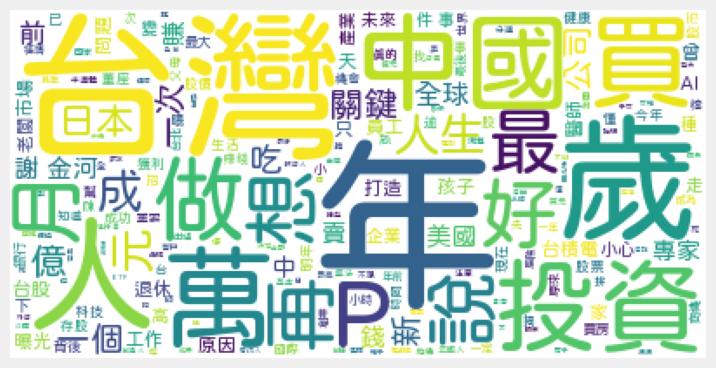

In [85]:
plt.figure(figsize = (8, 6))
wc = WordCloud(background_color = "white", font_path = my_font_path)
wc.generate(seg_list)

plt.imshow(wc)
plt.axis("off")
plt.show()